#Para ejecutar mas codigo y que vaya más rápido




#Carga datos

In [ ]:
import tensorflow as tf
import numpy as np 
import json
import time
import matplotlib.pyplot as plt
import os
import re
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#funciones para la carga de datos

def get_common_events(npy_dir_base,tels=None,run=None):
    #esta funcion nos sirve para obtener los indices de eventos comunes tal que 
    #esto es necesario para que las imagenes sean del mismo evento

    #TENEMOS QUE MIRAR PARA UNA RUN, TODOS LOS TELESCOPIOS QUE NOS INTERESEN,
    #SIN IMPORTAR EL ELEMENTO, SOLO LOS TELESCOPIOS DE LA RUN Y EL EMENTO QUE TOQUE
    lista=[]
    if (type(tels)==list) or (type(tels)==np.ndarray):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            regex=f"{npy_dir_base}/id_eventos_*_tel_{i}_run_{str(run).zfill(2)}.npy"
            aux=glob.glob(regex)
            if aux:
                lista.append(np.load(aux[0]))
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir_base)} no se encuentra el {os.path.basename(regex)}.")
                return None
    else:
        print("ERROR")
        return None
    if len(tels)==1:
        eventos_comunes=lista[0]
    else:
        sets=[set(i) for i in lista]
        #devolvemos una lista de los INDICES de los eventos que SON COMUNES y podemos coger
        eventos_comunes=sorted(list(sets[0].intersection(*sets[1:])))
        del sets
    indices_master=[]
    for i,j in enumerate(tels):
        indices=[]
        for k in eventos_comunes:
            indices.append(np.where(lista[i]==k)[0][0])
        indices_master.append(np.array(indices))
    #nos devuelve un array con tantas listas como telescopios con el indice donde estan los eventos con 
    #igual numero de evento
    #indices_master=[tel1:[eventos para la run],tel2:[eventos para la run]...]
    return np.array(indices_master)




def fill_holes(npy):
    npy_aux=npy.copy()
    if type(npy)!=np.ndarray:
        print("Error input")
        return
    #para cada elemento que sea cero lo rellenamos con la media de los vecinos
    indices=np.where(npy[1:-1,1:-1]==0)
    indices_1=indices[1]+1
    indices_0=indices[0]+1
    for i in range(indices_1.shape[0]):
        #esto se podría vectorizar
        media=(npy[indices_0[i]-1,indices_1[i]]+npy[indices_0[i],indices_1[i]-1]+npy[indices_0[i]+1,indices_1[i]]+npy[indices_0[i],indices_1[i]+1])/4
        npy_aux[indices_0[i],indices_1[i]]=media
    del npy
    return npy_aux


def load_data(npy_dir,tels=None,runs=None,indices_runs=None,only_names=False,ending=".npy"):
    #aplicamos regular expresions para extraer los documentos deseados
    #usamos glob
    #si no pasamos ni los tesls ni las runs, deolvemos todos los archivos
    #es poco optimo este uso de glob, pero es mas flexivo porque le puedo pasar los tels concretos y los runs concretos
    #si es return sin labels, nos devuelve todo, sin separar siquiera
    #el indices runs es para que solo nos devuelva los que queremos de cada archivo

    lista=[]
    if ((type(tels)==list) or (type(tels)==np.ndarray)):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            for j in runs:
                regex=f"{npy_dir}/*_tel_{i}_run_{str(j).zfill(2)}_?{ending}"
                aux=glob.glob(regex)
                if aux:
                    lista.extend(aux)
                else:
                    #si no lo encuentra entonces nos saldra mal la cosa
                    print("ERROR")
                    print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")
                    return None
    else:
        for j in runs:
            regex=f"{npy_dir}/*_tel_{tels}_run_{str(j).zfill(2)}_?{ending}"
            aux=glob.glob(regex)
            if aux:
                lista.extend(aux)
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")
                return None


    if only_names:
        return lista
    else:
        if indices_runs != None:
            
            if indices_runs[0].size==0:
            #Esta comprobacion la hacemos porque no sabemos si no comportarten ningun evento para esa primera run
                no_salir=True
                i=1
                while no_salir:
                    if indices_runs[i].size==0:
                        i+=1
                        if i==len(indices_runs):
                            return None
                    else:
                        lista_npy=np.load(lista[i])[indices_runs[i]]
                        no_salir=False
                        i+=1
                for m,k in enumerate(lista[i:]):
                    if indices_runs[m+i].size!= 0:
                        lista_npy=np.concatenate((lista_npy,np.load(k)[indices_runs[m+i]]),axis=0)
                return lista_npy
            else:
                lista_npy=np.load(lista[0])[indices_runs[0]]
                for m,k in enumerate(lista[1:]):
                    if indices_runs[m+1].size!= 0:
                        lista_npy=np.concatenate((lista_npy,np.load(k)[indices_runs[m+1]]),axis=0)
                return lista_npy

        else:
            lista_npy=np.load(lista[0])
            for m,k in enumerate(lista[1:]):
                lista_npy=np.concatenate((lista_npy,np.load(k)),axis=0)
            return lista_npy



#esta es la funcion master que lo junta todo en uno
#aqui indicamos los elementos que queremos que estén diferenciados en la clasificacion, así
#como las runs que queremos de cada uno de ellos
def load_dataset_ensemble(base_dir,elementos_clasif,pre_name_folders="npy_",telescopios=None,lista_list_runs=None,elementos=None,test_size=0.2,same_quant=False):
    #telescopios deb ser una lista , aunque solo haya uno 1
    #esta funcion es una version de load_dataset donde puedes escoger cuantas runs de cada elemento,
    #tambien (como en la otra, puedes decidir que haya mas o menos las mismas de todas same_quant)
    #list_RUNS Ahora es una lista de listas indicando para cada telescopio los indices de las runs 
    #indicamos los elementos que queremos que sean tomados en cuenta, pero el resto se les pone una label igual

    if elementos==None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    #para cada elemento y para cada RUN tenemos que indicar los eventos validos
    eventos_elementos=[]
    numero_eventos=[]
    for i,j in enumerate(elementos):
        dir_aux=f"{base_dir}/{pre_name_folders}{j}"
        eventos_runs=[]
        list_runs=lista_list_runs[i]
        aux_num_events=0
        for l,k in enumerate(list_runs):
            aux_events=get_common_events(dir_aux,tels=telescopios,run=k)
            print(j,k,list_runs,aux_events.shape)
            eventos_runs.append(aux_events)
            aux_num_events+=aux_events.shape[1]
        numero_eventos.append(aux_num_events)
        eventos_elementos.append(eventos_runs)
    #ahora tenemos los eventos que sí nos valen porque estan en todos los telescopios a considerar 
    x_train_list=[]
    x_test_list=[]
    print("_______________")
    last_aux_decider=0
    for l,k in enumerate(telescopios):
        for i,j in enumerate(elementos):
            dir_aux=f"{base_dir}/{pre_name_folders}{j}"
            list_runs=lista_list_runs[i]
            #TENEMOS QUE TENER UNA LISTA DE LOS INDICES QUE SÍ COMPARTEN ID, EL RESTO NO NOS INTERESA
            #lo que hacemos es pasarle una lista de los indices PARA:
            #PARA el elemento que toca y el telescopio qeu toca, para todas las runs que queremos 
            data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:] for m in eventos_elementos[i]],only_names=False)
            if data_aux != None:
                if same_quant:
                    media=int(np.median(numero_eventos))
                    data_aux=data_aux[:media]
                print(j,k,data_aux.shape)
                if l==0:
                    if j in elementos_clasif:
                        aux_decider=last_aux_decider+1
                        last_aux_decider+=1
                    else:
                        aux_decider=0
                if (i==0) :
                    if l==0:
                        label_size=data_aux.shape[0]
                        labels=np.ones(label_size)*aux_decider
                    data=data_aux
                else:
                    if l==0:
                        label_size=data_aux.shape[0]
                        labels=np.concatenate((labels,np.ones(label_size)*aux_decider),axis=0)
                    data=np.concatenate((data,data_aux),axis=0)
                    del data_aux
        #print(data.shape)
        #ahora le aumentamos el canal y las labels las volvemos categorical
        data=data[...,np.newaxis]
        if l==0:
            labels=tf.keras.utils.to_categorical(labels)
            x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=test_size,random_state=42)
            del data,labels
            y_train_list=y_train
            y_test_list=y_test
            x_train_list.append(x_train)
            x_test_list.append(x_test)
            #del y_train,y_test
        else:
            x_train,x_test =train_test_split(data,test_size=test_size,random_state=42)
            x_train_list.append(x_train)
            x_test_list.append(x_test)
            del data
        #del x_train,x_test

    if (x_train.shape[0]!=y_train.shape[0]) or (x_test.shape[0]!=y_test.shape[0]):
        print("Ha habido algún problema con las dimensiones y eso...te jodes lo siento")
        return None
    else:
        print("EXITO")
        if len(telescopios)==1:
            return x_train_list[0],x_test_list[0],y_train_list,y_test_list
        else:
            return x_train_list,x_test_list,y_train_list,y_test_list

#lo que nosotros necesitamos ahora es, poder indicar el telescopio del que queremos las runs
#los elementos que deben ir a la misma clasificación (mismo label), e indicar cuantas runs queremos de cada uno de ellos
#tambíen es importante que se pueda testar con un numero igual de features y asi tener un porcentaje de acierto real y no sesgado.

def load_dataset_completo(base_dir,labels_asign=None,elementos=None,lista_list_runs=None,pre_name_folders="npy_",telescopios=None,test_size=0.2,same_quant="same",verbose=True,fill=False,categorical=True):
    #LOS TELESCOPIOS EN UNA LISTA AUNQUE SEA 1
    #la estructura de datos esperada es una carpeta contenedora de las carpetas con los archivos npy
    #y prename folder es eso que va delante del nombre de la carpeta que tiene el nombre del elemento

    #poniendo las labels nosotros podemos escoger que dos entren dentro de la misma categoria 
    #a la hora de poner las labels_asign hay que tener en cuenta que si ponemos [0,1,2,6]
    #aunque solo haya 4 clases, se pensara que hay 7 pues va de 0 hasta 6. Siempre empieza en 0 y no puede saltarse ningun numero.

    #en él se indica los elementos que vamos a usar así como las labels que van a tener 
    #por ultimo da igual qeu tomemos muchas runs de uno si ponemos same_quant=same se nos quedará la cantidad exacata de cada
    #si ponemos same_quant=aprox mas o menos igual de cada uno  (se toma la mediana de la cantidad total de datos de cada clase considerada)
    #same_quant = "element" existe porque no es lo mis que haya la misma cantida por cada elemento qeu por cada label, entonces hay que tener eso en cuenta

    if elementos==None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']

    if labels_asign==None:
        labels_asign=np.array([0,1,2,3,4,5,6])
    else:
        labels_asign=np.array(labels_asign)

    if len(labels_asign)!=len(elementos):
        print("Error con la long de los elementos y los elementos")
        return None

    if len(lista_list_runs)!=len(elementos):
        #como lista_list_runs es una lista de las runs que vamos a tomar, pues deber haber una para cada elemento
        print("Error con la long de los elementos y las runs")
        return None


    #para cada elemento y para cada RUN tenemos que indicar los eventos validos
    eventos_elementos=[]
    numero_eventos=[]
    for i,j in enumerate(elementos):
        dir_aux=f"{base_dir}/{pre_name_folders}{j}"
        eventos_runs=[]
        list_runs=lista_list_runs[i]
        aux_num_events=0
        for l,k in enumerate(list_runs):
            #todo esto es para aplicar el get_common events a todas las runs que debemos comprobar
            aux_events=get_common_events(dir_aux,tels=telescopios,run=k)
            if verbose:
                print(j,k,list_runs,aux_events.shape)
            eventos_runs.append(aux_events)
            aux_num_events+=aux_events.shape[1]
        numero_eventos.append(aux_num_events)
        eventos_elementos.append(eventos_runs)
    #esto es lo mas lioso
    #eventos_elementos=[gamma:[run1:[tel1:[eventos en tel1 comunes entre telescopios en run 1 para gamma],tel2:[eventos],...],
                              #run2:[tel1:[eventos],tel2:[ev...]],run3:[...]] ,electron:[run1:[...],run2:[...]],....]


    #ahora tenemos los eventos que sí nos valen porque estan en todos los telescopios a considerar 
    x_train_list=[]
    x_test_list=[]

    if verbose:
        print("_______________")

    
    if (same_quant=="approx") :
        cantidad=int(np.median(numero_eventos))
            
    elif (same_quant=="same") :
        cantidad=int(np.amin(numero_eventos))
    elif same_quant=="element":
        #entonces tenemos que ver cual es el numero maximo de eventos que podemos tomar para cada elemento!!
        #tal que al final haya el mismo numero para cada label
        #esto es sabe quant per label
        #debemos sumar lo que tengan misma label y ver cual es el menor de ellos
        #cual es el menor de los numeros sumados con mismo label?
        numero_eventos=np.array(numero_eventos)
        unique_class=np.unique(labels_asign)
        num_class=len(unique_class)
        suma_labels=[np.sum(numero_eventos[i==labels_asign]) for i in unique_class]
        min_val_label=np.amin(suma_labels)
        cantidad=[]
        for i,j in enumerate(labels_asign):
            #contamos cuantas veces esta la cantidad esa minima y dividimos por el
            #numero de elementos que conforman esa clase
            cantidad.append(min_val_label//np.sum([j==aux_i for aux_i in labels_asign]))

    num_eventos_labels=[]
    for l,k in enumerate(telescopios):
        for i,j in enumerate(elementos):
            dir_aux=f"{base_dir}/{pre_name_folders}{j}"
            list_runs=lista_list_runs[i]
            #TENEMOS QUE TENER UNA LISTA DE LOS INDICES/eventos QUE SÍ COMPARTEN ID, EL RESTO NO NOS INTERESA
            #lo que hacemos es pasarle una lista de los indices PARA:
            #PARA el elemento que toca y el telescopio qeu toca, para todas las runs que queremos 
            data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:] for m in eventos_elementos[i]],only_names=False)

            #el tema del numero de eventos eta complicado porque ahora queremos el mismo de eventos para elementos con la misma label,
            #entonces por eso debemos de tener todos los de una misma label antes de reducirlo
            #pero por otro lado tambien debe haber la misma cantidad de subclases dentro de una misma label
            if same_quant=="element":
                #esto es sabe quant per label
                data_aux=data_aux[:cantidad[i]]
            elif same_quant in ["same","approx"]:
                data_aux=data_aux[:cantidad]
            elif same_quant=="all":
                pass

            if fill:
                #aplicamos la funcion que nos rellena todo
                for p in range(data_aux.shape[0]):
                    data_aux[p,:,:]=fill_holes(data_aux[p])

            if verbose:
                print(j,k,data_aux.shape)

            if i==0 :
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.ones(label_size)*labels_asign[i]
                data=data_aux
            else:
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.concatenate((labels,np.ones(label_size)*labels_asign[i]),axis=0)
                data=np.concatenate((data,data_aux),axis=0)
                del data_aux
        #ahora le aumentamos el canal y las labels las volvemos categorical
        data=data[...,np.newaxis]
        if l==0:
            if categorical:
                labels=tf.keras.utils.to_categorical(labels)
            x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=test_size,random_state=42)
            
            del data,labels
            y_train_list=y_train
            y_test_list=y_test
            x_train_list.append(x_train)
            x_test_list.append(x_test)
        else:
            x_train,x_test =train_test_split(data,test_size=test_size,random_state=42)
            x_train_list.append(x_train)
            x_test_list.append(x_test)
            del data

        if (x_train.shape[0]!=y_train.shape[0]) or (x_test.shape[0]!=y_test.shape[0]):
            print("Ha habido algún problema con las dimensiones y eso...te jodes lo siento")
            return None
        del x_train,x_test

    print("EXITO")
    if len(telescopios)==1:
        return x_train_list[0],x_test_list[0],y_train_list,y_test_list
    else:
        return x_train_list,x_test_list,y_train_list,y_test_list





#una funcion para crear la lista de list runs segun nos sea necesaria para indicar las runs a tomar de cada elemento
def create_lista_list_runs(num_events,init_events=None,random_select=False,elementos=None,max_runs=None):
    #solo tenemos que indicar la cantidad de runs que queremos de cada uno de los elementos
    #tambien podemos indicar el numero maximo de runs disponibles y si los queremos aleatorios
    if type(init_events)==int:
        if init_events==0:
            init_events=1
        init_events=np.ones(len(num_events))*init_events
    if elementos is None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    if max_runs is None:
        max_runs=[41,40,40,40,20,40,40]
    lista_master=[]
    for i,j in enumerate(num_events):
        if random_select:
            if j> max_runs[i]:
                print("No hay tantas runs.")
                list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=max_runs[i])
            else:
                list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=j)
        else: 
            if init_events is not None:
                if (j+init_events[i]-1)> max_runs[i]:
                    print(f"Error, para el {i} te estas pasando de run, no hay runs {np.arange(max_runs[i]+1,init_events[i]+j+1,dtype=int)}")
                    if init_events[i] > max_runs[i]:
                        list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=j)
                    else:
                        list_aux=np.arange(init_events[i],1+max_runs[i],dtype=int)
                else:
                    list_aux=np.arange(init_events[i],j+init_events[i],dtype=int)


            else:
                if (j) > max_runs[i]:
                    print(f"Error, para el \"{elementos[i]}\" te estas pasando de run, no hay run {np.arange(max_runs[i]+1,j+2,dtype=int)}")
                    list_aux=np.arange(1,max_runs[i]+1,dtype=int)
                else:
                    list_aux=np.arange(1,j+1,dtype=int)
        lista_master.append(list_aux)
    return np.array(lista_master,dtype=object)


#funcion que nos ayuda a mostar la matrix de confusion, necesita seaborn as sns
def print_conf_matrix(matrix,elements=None,sin_diag=True,save_dir=None):
    if elements is None:
        elements=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    if sin_diag:
        for i in range(len(elements)):
            matrix[i,i]=0
    plt.figure(figsize=(13,9))
    sns.heatmap(matrix,annot=True,annot_kws={'size':16})

    plt.yticks(np.arange(len(elements))+0.25,elements,fontsize=14,rotation=25);
    plt.xticks(np.arange(len(elements))+0.25,elements,fontsize=14,rotation=25);
    plt.title("True label in Y-axis, predicted label in X-axis", fontsize=15)
    if save_dir != None:
        plt.tight_layout()
        plt.savefig(save_dir)


def comp_and_diplay_conf_matrix(y_test,y_predict,elements=None,sin_diag=True,norm="true",save_dir=None):
    matrix=confusion_matrix(np.argmax(y_test,axis=-1),np.argmax(y_predict,axis=-1),normalize=norm)
    print_conf_matrix(matrix,elements=elements,sin_diag=sin_diag,save_dir=save_dir)



def display_max_errores(x_test,y_test,y_predicted,true_index=None,predict_index=None,sort_max=False):
    #primero tenemos que sacar aquellos que tengan maxima discrepancia entre lo predicho y lo real
    #sort max seria para sortearlas segun los maximo errores cometidos
    indices={}
    a=0
    if (true_index is None) or (predict_index is None):
        print("Dime que elemento quieres ver sus errores")
        return None

    if sort_max:
        #solo tenemos que meter primero a los que tengan mayor certeza de prediccion y asi ya nos sacara los erroneos
        indices_sort=np.argsort(y_predicted[:,predict_index])[::-1]
        #los mayores iran delante
        y_test=y_test[indices_sort]
        y_predicted=y_predicted[indices_sort]


    for i,j in enumerate(y_test):
        true_ind=np.argmax(j)
        predict_ind=np.argmax(y_predicted[i])
        if (true_ind!=predict_ind) and ((true_ind==true_index) and (predict_ind==predict_index)):
            indices[i]=y_predicted[i][predict_index], y_predicted[i][true_index]
    return indices

def plot_errors(x_test,y_test,y_predicho,true_index,predict_index,elementos=None,sort_max=False):

    if elementos is None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    a=display_max_errores(x_test,y_test,y_predicho,true_index=true_index,predict_index=predict_index,sort_max=sort_max)
    #vamos a ver algunos de los que se han confundido

    for i in range(0,8):
        fig=plt.figure(figsize=(10,8))
        indice=i #por orden natural
        indice_real= list(a)[indice]# el valor real en el x_test
        fig.suptitle(f"Se creyó que era {elementos[predict_index]} ({a[indice_real][0]*100:.2f}%), pero era {elementos[true_index]} ({a[indice_real][1]*100:.2f}%)",fontsize=15)
        for j in range(1,5):    
            plt.subplot(2,2,j)
            plt.imshow(x_test[j-1][indice_real][:,:,0])
            
        plt.tight_layout()

In [ ]:
#funciones necesarias
def list_txts(base_txt_dir,elemento,run):
    regex=f"{base_txt_dir}/*/{elemento}_tel_*_run_{str(run).zfill(2)}.txt"
    return sorted(glob.glob(regex),key=lambda x: int(re.findall("tel_([0-9]*)_",x)[0]))
 
def id_events(base_txt_dir,elemento,run):
    #buscamos todos los txt todos los numeros de eventos y luego los contamos solo una vez
    eventos=np.array([])
    listatxt=list_txts(base_txt_dir,elemento,run)
    if len(listatxt)==0:
        print(f"Algún error, no se han encontrado archivos de run {run} y elemento {elemento}.")
    for i,j in enumerate(listatxt):
        eventos=np.concatenate((eventos,extract_info_txt(j,cols=0)))
 
    return np.asarray(sorted(np.unique(eventos)))
 
def eventos_y_telescopios(base_txt_dir,elemento,run):
    #esta funcion nos crea un disccionario con el numero de evento y con los telescopios que forman parte
    #cuando abrimos una txt vemos que eventos hay dentro y añadimos al total los telescopios segun toque
    event_tels={}
    listatxt=list_txts(base_txt_dir,elemento,run)
    if len(listatxt)==0:
        print(f"Algún error, no se han encontrado archivos de run {run} y elemento {elemento}.")
    for i,j in enumerate(listatxt):
        tel_aux=int(re.findall("tel_([0-9]*)_",j)[0])
        events_aux=extract_info_txt(j,cols=0)
        for k in events_aux:
            if k not in event_tels.keys():
                event_tels[k]=[tel_aux]
            else:
                event_tels[k].append(tel_aux)
    return event_tels

def eventos_y_energia(base_txt_dir,elemento,run):
    #esta funcion nos crea un disccionario con el numero de evento y la nergia o algo asi que forman parte
    #cuando abrimos una txt vemos que eventos hay dentro y añadimos al total los telescopios segun toque
    event_tels={}
    #buscamos para todos los telescopios
    listatxt=list_txts(base_txt_dir,elemento,run)
    if len(listatxt)==0:
        print(f"Algún error, no se han encontrado archivos de run {run} y elemento {elemento}.")
    for i,j in enumerate(listatxt):
        events_aux=extract_info_txt(j,cols=[0,2])
        for p,k in enumerate(events_aux[0]):
            if k not in event_tels.keys():
                event_tels[k]=events_aux[1][p]
                
    return event_tels

def extract_info_txt(txt_dir,cols=None,cols_order=True):
  #extraer la informacion relevante de un archivo .txt
  #si se le pasan ciertas columnas se devolvera una lista solo con esas columnas
    cols_names=["event"
    ,"telescope"
    ,"energy"
    ,"core distance to telescope"
    ,"image size (amplitude) [p.e.]"
    ,"number of pixels in image"
    ,"width [deg.]"
    ,"length [deg.]"
    ,"distance [deg.]"
    ,"miss [deg.]"
    ,"alpha [deg.]"
    ,"orientation [deg.]"
    ,"direction [deg.]"
    ,"image c.o.g. x [deg.]"
    ,"image c.o.g. y [deg.]"
    ,"Xmax [g/cm^2]"
    ,"Hmax [m]"
    ,"Npe (true number of photo-electrons)"
    ,"(19-23): Hottest pixel amplitudes)"]
    with open(txt_dir,"r") as file:
        text_aux=file.read()
        a=re.findall(r'@\+[\s\d.-]*\d',text_aux)
        a=[i.replace("@+ ","").split() for i in a]
    if cols is None:
        return np.array(a).astype("float")
    elif type(cols)==list or type(cols)==np.array:
        list_aux=[]
        if cols_order :
            for i in cols:
                list_aux.append(np.array([float(j[i]) for j in a]))
            return np.array(list_aux).astype("float")
        else:
            list_aux=[]
            for i in a:
                list_aux.append(np.array([i[j] for j in cols ]))
            return np.array(list_aux).astype("float")
 
    else:
        return np.array([float(j[cols]) for j in a]).astype("float")


#ahora tenemos que apañar esto a lo grande
#le decimos unos telescopios, un elemento y una run y que nos devuelva una listao array con muchas
#primero vamos a hacer que dados un id de evento y unos telescopios,
#se nos forma la imagen de input
def big_input_img(tels,element,run,base_txt_dir,base_npy_dir,return_energies=False):
    shape1=(55,93)
    list_tels_shape1=[4,5,6,11,58,59,60,61,85,86]

    aux_ids=eventos_y_telescopios(base_txt_dir,element,run)

    if return_energies:
        energias=eventos_y_energia(base_txt_dir,element,run)
    #solo dejamos los que tengan los 4 telescopios en la lista
    set_tels=set(tels)
    aux_keys=list(aux_ids.keys())
    for i in aux_keys:
        if set(aux_ids[i]).issuperset(set_tels):
            pass
        else:
            if return_energies:
                del energias[i]
            del aux_ids[i]
 
    num_eventos=len(aux_ids)
    if return_energies:
        if len(energias)!= num_eventos:
            print("Algun error con la lengitud de las labels y los eventos etc.. yo que se...")
    #ahora es cuando tenemos que hacer imagen final a base de los diferentes telescopios, 
    #primero lo vamos a hacer sencillo, uno detras de otro y dejamos ceros si sobra
    #tenemos que buscar los indices par aluego buscarlo en el npy de imagenes
 
 
    #primero de todo creamos el array inicial donde los vamos a ir metiendo
    alto=55*2
    largo=93*2
 
    final_array=np.zeros((num_eventos,alto,largo))
    #vamos telescopio por telescopio
    if return_energies:
        labels_energias=[]
    posiciones=[[0,0],[55,0],[55,93],[0,93]] #rellenadas desde la esquina sup izqr counterclokwise
    for j,i in enumerate(tels):
        pos_aux=posiciones[j]
 
        #si está seguimos adelante cargando el evento
        #tenemos que cargar la lista y ver el indice para luego cargar el evento
        indices_aux=np.load(f"{base_npy_dir}/npy_{element}/id_eventos_npy_sin_normal_{element}_tel_{i}_run_{str(run).zfill(2)}.npy")
        comprobar_shape_1=indices_aux.shape[0]
        img_aux=np.load(f"{base_npy_dir}/npy_{element}/npy_sin_normal_{element}_tel_{i}_run_{str(run).zfill(2)}_0.npy")
        comprobar_shape_2=img_aux.shape[0]
        if comprobar_shape_1 != comprobar_shape_2:
            print(f"Error con las dimensiones del array de indices y el de imagenes para {element}: run {run}, tel {i}.")
        for k,id_evento in enumerate(aux_ids.keys()):
            if i in aux_ids[id_evento]:
                num_indice=np.where(indices_aux==id_evento)[0][0]
                img_aux_2=img_aux[num_indice]

                final_array[k,pos_aux[0]:(pos_aux[0]+55),pos_aux[1]:(pos_aux[1]+93)]=img_aux_2
            else:
                print("Error, se suponia que todos los eventos tenia todosl ostelescopios")
                pass
            
            if return_energies:
                if j==0:
                    try:
                        labels_energias.append(energias[id_evento])
                    except:
                        print("Algun error con las keys de los eventos y las de las energias, nu se...")
 
                #para el primer telescopio solo, no hace falta mas
 
    if return_energies:
        return final_array, labels_energias
    else:
        return final_array




#ahora hacemos para que esto lo haga para varias runs y todas juntas
def mult_runs_big_input_img(tels,element,runs,base_txt_dir,base_npy_dir,return_energies=False):
    if not return_energies:
        final=big_input_img(tels,element,runs[0],base_txt_dir,base_npy_dir)
        for i in runs[1:]:
            final=np.concatenate((final,big_input_img(tels,element,i,base_txt_dir,base_npy_dir)))
        return final
    else:
        final_array,final_labels=big_input_img(tels,element,runs[0],base_txt_dir,base_npy_dir,return_energies=True)
        for i in runs[1:]:
            aux1,aux2=big_input_img(tels,element,i,base_txt_dir,base_npy_dir,return_energies=True)
            final_array=np.concatenate((final_array,aux1))
            final_labels.extend(aux2)
        return final_array,final_labels


#una funcion para crear la lista de list runs segun nos sea necesaria para indicar las runs a tomar de cada elemento
def create_lista_list_runs(num_events,init_events=None,random_select=False,elementos=None,max_runs=None):
    #solo tenemos que indicar la cantidad de runs que queremos de cada uno de los elementos
    #tambien podemos indicar el numero maximo de runs disponibles y si los queremos aleatorios
    if type(init_events)==int:
        if init_events==0:
            init_events=1
        init_events=np.ones(len(num_events))*init_events
    if elementos is None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    if max_runs is None:
        max_runs=[41,40,40,40,20,40,40]
    lista_master=[]
    for i,j in enumerate(num_events):
        if random_select:
            if j> max_runs[i]:
                print("No hay tantas runs.")
                list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=max_runs[i])
            else:
                list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=j)
        else: 
            if init_events is not None:
                if (j+init_events[i]-1)> max_runs[i]:
                    print(f"Error, para el {i} te estas pasando de run, no hay runs {np.arange(max_runs[i]+1,init_events[i]+j+1,dtype=int)}")
                    if init_events[i] > max_runs[i]:
                        list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=j)
                    else:
                        list_aux=np.arange(init_events[i],1+max_runs[i],dtype=int)
                else:
                    list_aux=np.arange(init_events[i],j+init_events[i],dtype=int)
 
 
            else:
                if (j) > max_runs[i]:
                    print(f"Error, para el \"{elementos[i]}\" te estas pasando de run, no hay run {np.arange(max_runs[i]+1,j+2,dtype=int)}")
                    list_aux=np.arange(1,max_runs[i]+1,dtype=int)
                else:
                    list_aux=np.arange(1,j+1,dtype=int)
        lista_master.append(list_aux)
    return np.array(lista_master,dtype=object)



#final dataset function
#le pasamos los elementos y las runs que queremos de cada y obtenemos el dataset 
#con sus labels y todo. Las labels tambien las personalizamos
 
def data_set_longinput(tels,runs_list,base_txt_dir,base_npy_dir,labels=None,elements=None,test_size=0.2):
    if elements is None:
        elements=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
        if labels is None:
            labels=[0,1,2,3,4,5,6]
    else:
        if labels is None:
            labels=np.arange(len(elements))
    if len(elements)!= len(labels):
        print("Error con la long de las labels y los elementos.")
        return None
    features_list=mult_runs_big_input_img(tels,elements[0],runs_list[0],base_txt_dir,base_npy_dir)
    labels_array=np.ones(features_list.shape[0])*labels[0]
    print(elements[0],features_list.shape[0],features_list.shape,labels_array.shape)
    for i,j in enumerate(elements[1:]):
        aux_element=mult_runs_big_input_img(tels,j,runs_list[i+1],base_txt_dir,base_npy_dir)
        features_list=np.concatenate((features_list,aux_element))
        labels_array=np.concatenate((labels_array,np.ones(aux_element.shape[0])*labels[i+1]))
        print(elements[i+1],aux_element.shape[0],features_list.shape,labels_array.shape)
    features_list=features_list[...,np.newaxis]
    labels_array=tf.keras.utils.to_categorical(labels_array)
    x_train,x_test,y_train,y_test=train_test_split(features_list,labels_array,random_state=42,test_size=test_size)
    return x_train,x_test,y_train,y_test

In [ ]:


def model_1_tel(input_shape=(55,93,1),filtros=None,batch_init=True,last_layers=None,avg_pooling=False,classes=3,learning_rate=1e-5,first_model=None,first_part=False):
    if filtros is None:
        filtros=[[64,32],[128,64,64],[32,16]]
    if last_layers is None:
        last_layers=[35,20]
    #lo vamos a hacer super customizable para probar esa vaina de entrenar muchos hiperparametros
    #estructura lo que nos mete son el numero de filtros conv y maxpool
    model=tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=input_shape)])
    if first_model:
        first_model.trainable=False
        model.add(first_model)
    if batch_init:
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation("relu"))
    for i,j in enumerate(filtros):
        #aqui se alterna entre conv y maxpool(1) o average pool(-1)
        for k in j:
            model.add(tf.keras.layers.Conv2D(k,3,activation="relu",padding="same"))
        if avg_pooling:
            model.add(tf.keras.layers.AveragePooling2D((2,2)))
        else:
            model.add(tf.keras.layers.MaxPool2D((2,2)))
    model.add(tf.keras.layers.Flatten())
    if first_part:
        return model
    for j,i in enumerate(last_layers):
        model.add(tf.keras.layers.Dense(i,activation="relu"))
    model.add(tf.keras.layers.Dense(classes,activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="categorical_crossentropy",metrics=["accuracy"])

    return model


In [ ]:
#ahora creamos el model con el encoder primero
#encoder=tf.keras.models.load_model(f"/content/drive/MyDrive/MAIN_TFG/final_results/resultados_autoencoder/encoder_modelountelescopio_110_mid45.h5")

#tenemos que recortar de las imagenes de forma que sean 52/92-....
def model_encoder(layers,encoder,output=3):

    model=tf.keras.Sequential()
    model.add(encoder)
    for i,j in enumerate(layers):
        model.add(tf.keras.layers.Dense(j,activation="relu"))

    model.add(tf.keras.layers.Dense(output,activation="softmax"))
    return model

In [ ]:
def model_multi_tel(len_inputs=4,input_shapes=[(55,93,1)],classes=7,learning_rate=1e-5,pre_proces_model=None,filtros=None,last_dense=None,autoencoder=None,common_pre=True,batch=False):
    inputs=[]
    outputs=[[] for i in range(len_inputs)]
    if len(input_shapes)==1:
        for i in range(1,len_inputs):
            input_shapes.append(input_shapes[0])

    for i in range(len_inputs):
        inputs.append(tf.keras.Input(shape=input_shapes[i]))

    if pre_proces_model:
        for i in range(len_inputs):
            outputs[i]=pre_proces_model(first_model=autoencoder)(inputs[i])
    else:
        if filtros is None:
            filtros=[[64,128],[128,254,64],[32]]
        #si no le metemos un modelo pues habra que meter aqui chicha porque sino se queda esto muy vacio
        if common_pre:
            pre_model=model_1_tel(input_shapes[0],filtros=filtros,first_part=True,first_model=autoencoder,batch_init=batch)
            outputs[0]=pre_model(inputs[0])
            for i in range(1,len_inputs):
                if input_shapes[i]!=input_shapes[i-1]:
                #esto esta suponiendo que ponemos juntos los que tienen igual shape
                    pre_model=model_1_tel(input_shapes[i],filtros=filtros,first_part=True,first_model=autoencoder,batch_init=batch) 
                outputs[i]=pre_model(inputs[i])

        else:
            for i in range(len_inputs):
                #SI QUEREMOS PONER AUTOENCODER TENEMOS QUE VER LA FOTMA DE COPIARLO
                pre_model=model_1_tel(input_shape=input_shapes[i],filtros=filtros,first_part=True,batch_init=batch)
                outputs[i]=pre_model(inputs[i]) 
    #nos falta la ultima parte
    if last_dense is None:
        last_dense=[65,35]
    x=tf.keras.layers.concatenate(outputs)
    for i in last_dense:
        x=tf.keras.layers.Dense(i,activation="relu",kernel_regularizer="l2")(x)
    end_layer=tf.keras.layers.Dense(classes,activation="softmax")(x)
    model=tf.keras.Model(inputs=inputs,outputs=end_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="categorical_crossentropy",metrics=["accuracy"])

    return model


In [ ]:
def model_multi_tel_encoder(len_inputs=4,input_shapes=[(55,93,1)],classes=3,last_dense=None,encoder=None,common_pre=True): #,learning_rate=1e-5
    inputs=[]
    outputs=[[] for i in range(len_inputs)]
    if len(input_shapes)==1:
        for i in range(1,len_inputs):
            input_shapes.append(input_shapes[0])

    for i in range(len_inputs):
        inputs.append(tf.keras.Input(shape=input_shapes[i]))


    if common_pre:
        outputs[0]=encoder(inputs[0])
        for i in range(1,len_inputs):
            #if input_shapes[i]!=input_shapes[i-1]:
            #esto esta suponiendo que ponemos juntos los que tienen igual shape
            #    pre_model=model_1_tel(input_shapes[i],filtros=filtros,first_part=True,first_model=autoencoder) 
            outputs[i]=encoder(inputs[i])

    else:
        for i in range(len_inputs):
            #SI QUEREMOS PONER AUTOENCODER TENEMOS QUE VER LA FOTMA DE COPIARLO
            pre_model=model_1_tel(input_shape=input_shapes[i],filtros=filtros,first_part=True,batch_init=batch)
            outputs[i]=pre_model(inputs[i]) 
    #nos falta la ultima parte
    if last_dense is None:
        last_dense=[65,35]
    x=tf.keras.layers.concatenate(outputs)
    for i in last_dense:
        x=tf.keras.layers.Dense(i,activation="relu",kernel_regularizer="l2")(x)
    end_layer=tf.keras.layers.Dense(classes,activation="softmax")(x)
    model=tf.keras.Model(inputs=inputs,outputs=end_layer)
    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="categorical_crossentropy",metrics=["accuracy"])

    return model


#Innecesario 1TEL SIN AUTOENCODER, ARQUITECTURA
No se si he explorado muy buenas arquitecturas...

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

a=create_lista_list_runs(num_events=[5,39,39,39,20,39,39],random_select=False)
x_train,x_test,y_train,y_test=load_dataset_completo(npy_base,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon'],labels_asign=[0,1,2,2,2,2,2],lista_list_runs=a,telescopios=[4],test_size=0.2,same_quant="approx",fill=True,verbose=True)

In [ ]:
ruta_save="/content/drive/MyDrive/MAIN_TFG/final_results/resultados_classif"
param_distribs = {
 "filtros": [[[16,32],[32,64],[64],[32,16,6]], [[8,16],[32,32],[64],[32,16,6]],[[8,16,32],[32],[64],[16,4]]],
 "last_layers":[[100,50],[200,50],[50]]
}

aux1=json.dumps(param_distribs)
with open("/content/drive/MyDrive/MAIN_TFG/final_results/resultados_classif/parametros5.json","w") as fil:
    fil.write(aux1)

for m,i in enumerate(param_distribs["filtros"]):
    resultados={}
    for k in param_distribs["last_layers"]:
        start=time.time()
        print(i,k,"\n","_____________________","\n")
        model=model_1_tel(filtros=i,batch_init=False,last_layers=k,learning_rate=2e-6)
        hist=model.fit(x_train,y_train,epochs=80,validation_data=(x_test,y_test))
        resultados[f"{i}, {k}"]=hist.history
        stop=time.time()
        print(stop-start,"\n")
    #despues de cada una de estas lo ponemos a guardar
    aux2=json.dumps(resultados)
    with open(f"/content/drive/MyDrive/MAIN_TFG/final_results/resultados_classif/resultados5_parte{m+1}.json","w") as fil2:
        fil2.write(aux2)


#1 TEL + ENCODER 
Tengo que hacer más porque no se estanca 

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

a=create_lista_list_runs(num_events=[5,39,31,39,20,33,33],random_select=False)
x_train,x_test,y_train,y_test=load_dataset_completo(npy_base,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon'],labels_asign=[0,1,2,2,2,2,2],lista_list_runs=a,telescopios=[4],test_size=0.2,same_quant="approx",fill=True,verbose=True)

gamma 1 [1 2 3 4 5] (1, 1999)
gamma 2 [1 2 3 4 5] (1, 1999)
gamma 3 [1 2 3 4 5] (1, 1999)
gamma 4 [1 2 3 4 5] (1, 1998)
gamma 5 [1 2 3 4 5] (1, 1998)
electron 1 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (1, 214)
electron 2 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (1, 194)
electron 3 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (1, 172)
electron 4 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (1, 210)
electron 5 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (1, 203)
electron 6 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (1, 205)
electron 7

In [ ]:
#primero limitamos los datos de la forma que hemos hecho antes
x_train_new=x_train[:,1:-2,:-1]
x_test_new=x_test[:,1:-2,:-1]

In [ ]:
lista_opciones={"layers":[[40,20,16,16],[500],[400,10],[80,50,20]]}
                #"dropout":[]}


aux1=json.dumps(lista_opciones)
with open("/content/drive/MyDrive/MAIN_TFG/final_results/resultados_classif/parametros_usoencoder4_trainableencoder.json","w") as fil:
    fil.write(aux1)

resultados={}
resultados2={}

for i in lista_opciones["layers"]:
    encoder=tf.keras.models.load_model(f"/content/drive/MyDrive/MAIN_TFG/final_results/resultados_autoencoder/encoder_modelountelescopio_110_mid45.h5")
    encoder.trainable=False
    learning_rate=5e-5
    print(i,"\n","_____________________","\n")
    model=model_encoder(i,encoder=encoder)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="categorical_crossentropy",metrics=["accuracy"])
    encoder.trainable=False

    hist=model.fit(x_train_new,y_train,epochs=65,validation_data=(x_test_new,y_test))
    resultados[f"{i}"]=hist.history
    learning_rate=5e-5
    encoder.trainable=True
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="categorical_crossentropy",metrics=["accuracy"])
    hist2=model.fit(x_train_new,y_train,epochs=30,validation_data=(x_test_new,y_test))
    resultados2[f"{i}"]=hist2.history

aux2=json.dumps(resultados)
with open(f"/content/drive/MyDrive/MAIN_TFG/final_results/resultados_classif/resultados_usoencoder4_trainableencoder_part1.json","w") as fil2:
    fil2.write(aux2)

aux2=json.dumps(resultados2)
with open(f"/content/drive/MyDrive/MAIN_TFG/final_results/resultados_classif/resultados_usoencoder4_trainableencoder_part2.json","w") as fil2:
    fil2.write(aux2)


[40, 20, 16, 16] 
 _____________________ 

Epoch 1/65
1859/1859 [==============================] - 24s 5ms/step - loss: 2.5484 - accuracy: 0.6578 - val_loss: 1.0322 - val_accuracy: 0.7438
Epoch 2/65
1859/1859 [==============================] - 8s 5ms/step - loss: 0.8311 - accuracy: 0.8062 - val_loss: 0.6795 - val_accuracy: 0.8478
Epoch 3/65
1859/1859 [==============================] - 8s 5ms/step - loss: 0.5973 - accuracy: 0.8633 - val_loss: 0.5167 - val_accuracy: 0.8778
Epoch 4/65
1859/1859 [==============================] - 8s 5ms/step - loss: 0.4710 - accuracy: 0.8838 - val_loss: 0.4264 - val_accuracy: 0.8914
Epoch 5/65
1859/1859 [==============================] - 8s 5ms/step - loss: 0.3981 - accuracy: 0.8944 - val_loss: 0.3714 - val_accuracy: 0.8999
Epoch 6/65
1859/1859 [==============================] - 8s 5ms/step - loss: 0.3539 - accuracy: 0.9007 - val_loss: 0.3406 - val_accuracy: 0.9054
Epoch 7/65
1859/1859 [==============================] - 8s 5ms/step - loss: 0.3267 - accurac

# Group labels 1 tels REHACER 3 CONF MATRICES

In [ ]:
#cargamos los datos una vez con diferentes labels 
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
a=create_lista_list_runs(num_events=[6,33,30,35,20,39,33],random_select=False)
x_train,x_test,y_train,y_test=load_dataset_completo(npy_base,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon'],labels_asign=[0,1,2,3,4,5,6],lista_list_runs=a,telescopios=[4],test_size=0.2,same_quant="approx",fill=True,verbose=True,categorical=False)

gamma 1 [1 2 3 4 5 6] (1, 1999)
gamma 2 [1 2 3 4 5 6] (1, 1999)
gamma 3 [1 2 3 4 5 6] (1, 1999)
gamma 4 [1 2 3 4 5 6] (1, 1998)
gamma 5 [1 2 3 4 5 6] (1, 1998)
gamma 6 [1 2 3 4 5 6] (1, 1999)
electron 1 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33] (1, 214)
electron 2 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33] (1, 194)
electron 3 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33] (1, 172)
electron 4 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33] (1, 210)
electron 5 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33] (1, 203)
electron 6 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33] (1, 205)
electron 7 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 2

Epoch 1/50
963/963 [==============================] - 32s 31ms/step - loss: 2.0448 - accuracy: 0.9255 - val_loss: 1.7955 - val_accuracy: 0.9422
Epoch 2/50
963/963 [==============================] - 29s 31ms/step - loss: 1.6624 - accuracy: 0.9457 - val_loss: 1.5354 - val_accuracy: 0.9498
Epoch 3/50
963/963 [==============================] - 29s 31ms/step - loss: 1.4268 - accuracy: 0.9499 - val_loss: 1.3302 - val_accuracy: 0.9506
Epoch 4/50
963/963 [==============================] - 29s 31ms/step - loss: 1.2425 - accuracy: 0.9518 - val_loss: 1.1679 - val_accuracy: 0.9559
Epoch 5/50
963/963 [==============================] - 29s 31ms/step - loss: 1.0991 - accuracy: 0.9538 - val_loss: 1.0564 - val_accuracy: 0.9508
Epoch 6/50
963/963 [==============================] - 29s 31ms/step - loss: 0.9878 - accuracy: 0.9554 - val_loss: 0.9443 - val_accuracy: 0.9550
Epoch 7/50
963/963 [==============================] - 29s 31ms/step - loss: 0.8984 - accuracy: 0.9565 - val_loss: 0.8672 - val_accuracy:

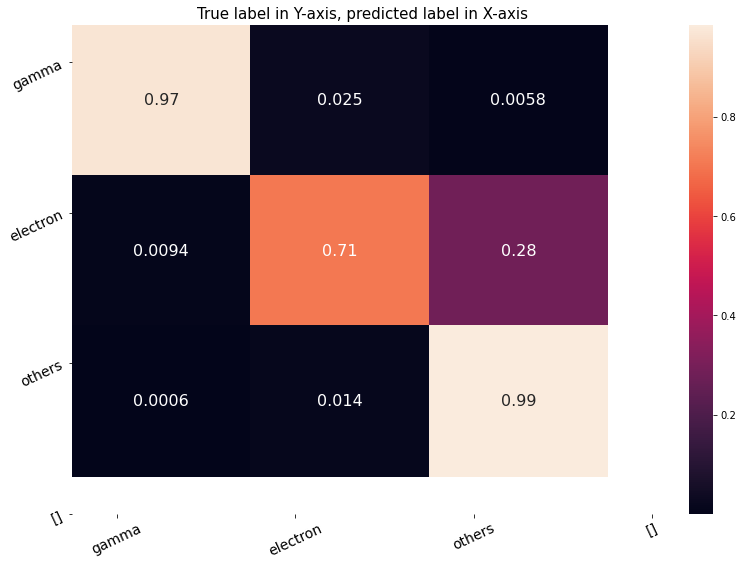

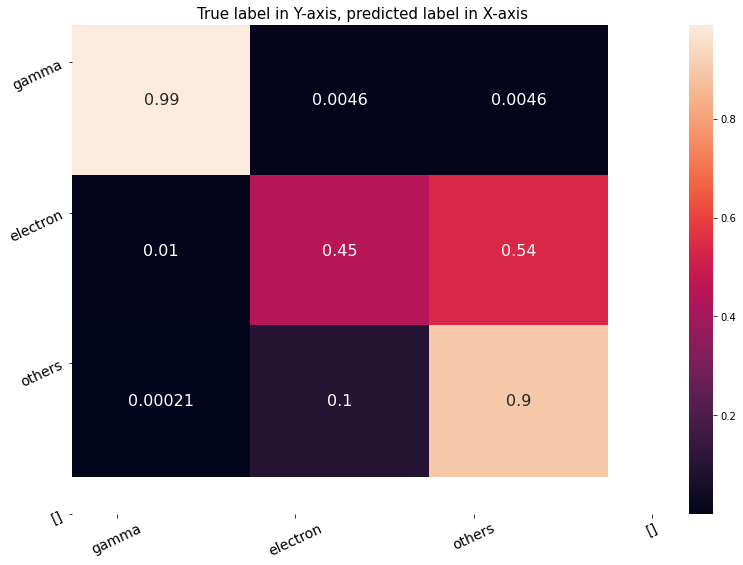

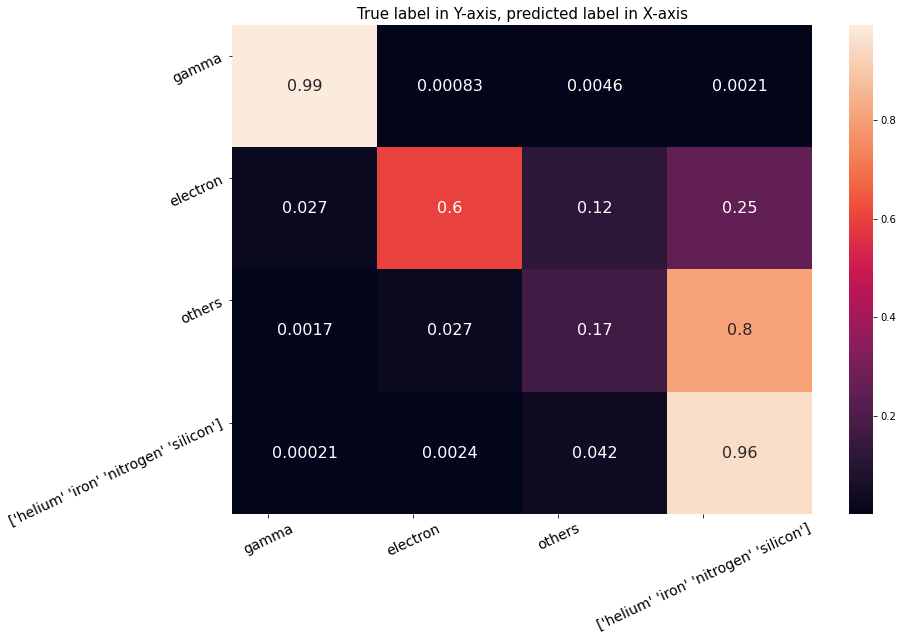

In [ ]:
#prueba 4 telescopio diferentes agrupaciones 
#vamos a darle diferentes labels
elements=np.array(["gamma","electron",'proton', 'helium', 'iron', 'nitrogen', 'silicon'])
aux_save_dir="/content/drive/MyDrive/MAIN_TFG/final_results/agrupaciones_1_telescopio"
lista_labels=np.array([[0,1,2,2,2,2,2],[0,1,1,2,2,2,2],[0,1,2,3,3,3,3]])
"""
[0,1,3,3,2,2,3],
[0,1,3,2,3,3,2],[0,1,3,2,3,2,3],[0,1,3,2,2,3,3],[0,1,2,3,3,3,2],[0,1,2,3,3,2,3],[0,1,2,3,2,3,3],[0,1,2,2,3,3,3]
[0,1,2,2,3,2,3],[0,1,2,2,2,3,3],[0,1,3,3,3,2,2],[0,1,3,3,2,3,2],
[0,1,1,2,2,2,2],[0,1,2,1,2,2,2],[0,1,1,2,2,3,3],[0,1,1,1,2,2,2],[0,1,1,2,3,2,3],[0,1,1,1,2,1,2],[0,1,2,2,3,1,3],[0,1,1,2,3,1,3],[0,1,1,2,2,1,2],
                       [0,1,3,2,2,2,2],[0,1,2,3,2,2,2],[0,1,2,2,3,2,2],[0,1,2,2,2,3,2],[0,1,2,2,2,2,3],[0,1,2,2,2,2,2],
                       [0,1,3,3,2,2,2],[0,1,3,2,3,2,2],[0,1,3,2,2,3,2],[0,1,3,2,2,2,3],[0,1,2,3,3,2,2],[0,1,2,3,2,3,2],

"""


#with open(f"{aux_save_dir}/agrupaciones_4tel_parte_{i_aux}.json","r") as fil2:
#    fil2.write(aux2)

i_aux=4
hist_total={}
for i,j in enumerate(lista_labels):
    #vamos a cambiar los y_test y y_train
    y_train_new=y_train.copy()
    y_test_new=y_test.copy()
    for m,n in enumerate(j):
        y_train_new[y_train==m]=n
        y_test_new[y_test==m]=n
    y_train_new=tf.keras.utils.to_categorical(y_train_new)
    y_test_new=tf.keras.utils.to_categorical(y_test_new)

    model=model_multi_tel(len_inputs=1,input_shapes=[(55,93,1)],classes=len(np.unique(j)),learning_rate=3e-5,last_dense=[150,50],filtros=[[32, 64], [128, 256], [64, 32], [16, 6]],common_pre=True)
    hist_aux=model.fit(x_train,y_train_new,epochs=50,batch_size=64,validation_data=(x_test,y_test_new))

    #vamos a guardar la conf matrix y la hist

    hist_total[str(j)]=hist_aux.history
    comp_and_diplay_conf_matrix(y_test_new,model.predict(x_test),["gamma","electron","others",str(elements[j==3])],sin_diag=False)
    plt.savefig(f"{aux_save_dir}/{str(j)}_confmatrix_1tels_rehecha.png")
    aux2=json.dumps(hist_total)
    #with open(f"{aux_save_dir}/agrupaciones_4tel_parte_{i_aux}.json","w") as fil2:
    #    fil2.write(aux2)
    print(i+1, "de", len(lista_labels),"\n")
print("Termino!")



# Group labels 4 tels +confusion matrix

In [ ]:
#cargamos los datos una vez con diferentes labels 
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
a=create_lista_list_runs(num_events=[6,33,30,35,20,39,33],random_select=False)
x_train,x_test,y_train,y_test=load_dataset_completo(npy_base,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon'],labels_asign=[0,1,2,3,4,5,6],lista_list_runs=a,telescopios=[4,5,6,11],test_size=0.2,same_quant="approx",fill=True,verbose=True,categorical=False)

gamma 1 [1 2 3 4 5 6] (4, 1999)
gamma 2 [1 2 3 4 5 6] (4, 1999)
gamma 3 [1 2 3 4 5 6] (4, 1999)
gamma 4 [1 2 3 4 5 6] (4, 1997)
gamma 5 [1 2 3 4 5 6] (4, 1998)
gamma 6 [1 2 3 4 5 6] (4, 1998)
electron 1 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33] (4, 115)
electron 2 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33] (4, 106)
electron 3 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33] (4, 104)
electron 4 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33] (4, 128)
electron 5 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33] (4, 128)
electron 6 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33] (4, 122)
electron 7 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 2

In [ ]:
#prueba 4 telescopio diferentes agrupaciones 
#vamos a darle diferentes labels
elements=np.array(["gamma","electron",'proton', 'helium', 'iron', 'nitrogen', 'silicon'])
aux_save_dir="/content/drive/MyDrive/MAIN_TFG/final_results/agrupaciones_4_telescopios"
lista_labels=np.array([[0,1,2,2,2,2,2],[0,1,2,2,3,2,2]])
"""
[0,1,3,3,2,2,3],
[0,1,3,2,3,3,2],[0,1,3,2,3,2,3],[0,1,3,2,2,3,3],[0,1,2,3,3,3,2],[0,1,2,3,3,2,3],[0,1,2,3,2,3,3],[0,1,2,2,3,3,3]
[0,1,2,2,3,2,3],[0,1,2,2,2,3,3],[0,1,3,3,3,2,2],[0,1,3,3,2,3,2],
[0,1,1,2,2,2,2],[0,1,2,1,2,2,2],[0,1,1,2,2,3,3],[0,1,1,1,2,2,2],[0,1,1,2,3,2,3],[0,1,1,1,2,1,2],[0,1,2,2,3,1,3],[0,1,1,2,3,1,3],[0,1,1,2,2,1,2],
                       [0,1,3,2,2,2,2],[0,1,2,3,2,2,2],[0,1,2,2,3,2,2],[0,1,2,2,2,3,2],[0,1,2,2,2,2,3],[0,1,2,2,2,2,2],
                       [0,1,3,3,2,2,2],[0,1,3,2,3,2,2],[0,1,3,2,2,3,2],[0,1,3,2,2,2,3],[0,1,2,3,3,2,2],[0,1,2,3,2,3,2],

"""


#with open(f"{aux_save_dir}/agrupaciones_4tel_parte_{i_aux}.json","r") as fil2:
#    fil2.write(aux2)

i_aux=4
hist_total={}
for i,j in enumerate(lista_labels):
    #vamos a cambiar los y_test y y_train
    y_train_new=y_train.copy()
    y_test_new=y_test.copy()
    for m,n in enumerate(j):
        y_train_new[y_train==m]=n
        y_test_new[y_test==m]=n
    y_train_new=tf.keras.utils.to_categorical(y_train_new)
    y_test_new=tf.keras.utils.to_categorical(y_test_new)

    model=model_multi_tel(len_inputs=4,input_shapes=[(55,93,1)],classes=len(np.unique(j)),learning_rate=3e-5,last_dense=[150,50],filtros=[[32, 64], [128, 256], [64, 32], [16, 6]],common_pre=True)
    hist_aux=model.fit(x_train,y_train_new,epochs=50,batch_size=64,validation_data=(x_test,y_test_new))

    #vamos a guardar la conf matrix y la hist

    hist_total[str(j)]=hist_aux.history
    comp_and_diplay_conf_matrix(y_test_new,model.predict(x_test),["gamma","electron","others",str(elements[j==3])],sin_diag=False)
    plt.savefig(f"{aux_save_dir}/{str(j)}_confmatrix_4tels_rechecha.png")
    #aux2=json.dumps(hist_total)
    #with open(f"{aux_save_dir}/agrupaciones_4tel_parte_{i_aux}.json","w") as fil2:
    #    fil2.write(aux2)
    print(i+1, "de", len(lista_labels),"\n")
print("Termino!")



# 4TELS SIN ENCODER ARQUITECTURA
Tener algunas archs que sean como el encoder

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

a=create_lista_list_runs(num_events=[8,39,39,39,20,39,39],random_select=False)
x_train,x_test,y_train,y_test=load_dataset_completo(npy_base,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon'],labels_asign=[0,1,2,2,2,2,2],lista_list_runs=a,telescopios=[4,5,6,11],test_size=0.2,same_quant="approx",fill=True,verbose=True)

In [ ]:
ruta_save="/content/drive/MyDrive/MAIN_TFG/final_results/resultados_classif"
#param_distribs = {
# "filtros": [[[16,32],[32,64],[64],[32,16,4]], [[8,16],[32,32],[64],[32,16,4]],[[8,16,32],[32],[64],[16,4]]],
# "last_layers":[[200,50],[400,50],[50],[300]]
#}

with open("/content/drive/MyDrive/MAIN_TFG/final_results/resultados_classif/parametros2.json","r") as json_file:
        param_distribs = json.load(json_file)

#aux1=json.dumps(param_distribs)
#with open("/content/drive/MyDrive/MAIN_TFG/final_results/resultados_classif/multiinput_parametros2.json","w") as fil:
#    fil.write(aux1)

for m,i in enumerate(param_distribs["filtros"][2:]):
    resultados={}
    for k in param_distribs["last_layers"]:
        start=time.time()
        print(i,k,"\n","_____________________","\n")
        model=model_multi_tel(len_inputs=4,input_shapes=[(55,93,1)],classes=3,learning_rate=6e-5,
                  pre_proces_model=None,last_dense=k,filtros=i,common_pre=True)
        hist=model.fit(x_train,y_train,epochs=80,validation_data=(x_test,y_test))
        resultados[f"{i}, {k}"]=hist.history
        stop=time.time()
        print(stop-start,"\n")
    #despues de cada una de estas lo ponemos a guardar
    #aux2=json.dumps(resultados)
    #with open(f"/content/drive/MyDrive/MAIN_TFG/final_results/resultados_classif/multiinput_resultados2_parte{m+3}.json","w") as fil2:
    #    fil2.write(aux2)


# 4TELS + ENCODER 
aumentar los rangos para que sature.

¡Importante la argumentacion de que el modelo si lo entrenamos ya no usa la parte de encoder...!

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

a=create_lista_list_runs(num_events=[8,39,39,39,20,39,39],random_select=False)
x_train,x_test,y_train,y_test=load_dataset_completo(npy_base,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon'],labels_asign=[0,1,2,2,2,2,2],lista_list_runs=a,telescopios=[4,5,6,11],test_size=0.2,same_quant="approx",fill=True,verbose=True)

gamma 1 [1 2 3 4 5 6 7 8] (4, 1999)
gamma 2 [1 2 3 4 5 6 7 8] (4, 1999)
gamma 3 [1 2 3 4 5 6 7 8] (4, 1999)
gamma 4 [1 2 3 4 5 6 7 8] (4, 1997)
gamma 5 [1 2 3 4 5 6 7 8] (4, 1998)
gamma 6 [1 2 3 4 5 6 7 8] (4, 1998)
gamma 7 [1 2 3 4 5 6 7 8] (4, 1999)
gamma 8 [1 2 3 4 5 6 7 8] (4, 1997)
electron 1 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (4, 115)
electron 2 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (4, 106)
electron 3 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (4, 104)
electron 4 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (4, 128)
electron 5 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (4, 128)
electron 6 [

In [ ]:
#primero limitamos los datos de la forma que hemos hecho antes
x_train_new=[]
x_test_new=[]
for i in range(4):
    x_train_new.append(x_train[i][:,1:-2,:-1])
    x_test_new.append(x_test[i][:,1:-2,:-1])

In [ ]:
lista_opciones={"layers":[[10],[20],[30,10]]}
#lista_opciones={"layers":[[600,100,30],[500],[100],[100,60,40,20,10],[40,40,40,10],[20,20,20,20,20,10]]}
                #"dropout":[]}

#esto esta mal, el encoder debe ser cardado de cero cada vez


aux1=json.dumps(lista_opciones)
with open("/content/drive/MyDrive/MAIN_TFG/final_results/resultados_classif/multiinput_parametros4_usoencoder_trainableencoder.json","w") as fil:
    fil.write(aux1)

resultados={}
resultados2={}

for i in lista_opciones["layers"]:
    encoder=tf.keras.models.load_model(f"/content/drive/MyDrive/MAIN_TFG/final_results/resultados_autoencoder/encoder_modelountelescopio_110_mid45.h5")
    encoder.trainable=False
    learning_rate=5e-5
    print(i,"\n","_____________________","\n")
    model=model_multi_tel_encoder(len_inputs=4,input_shapes=[(52,92,1)],classes=3,last_dense=i,encoder=encoder)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="categorical_crossentropy",metrics=["accuracy"])
    hist=model.fit(x_train_new,y_train,epochs=60,validation_data=(x_test_new,y_test))
    resultados[f"{i}"]=hist.history
    learning_rate=5e-5
    encoder.trainable=True
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="categorical_crossentropy",metrics=["accuracy"])
    hist2=model.fit(x_train_new,y_train,epochs=30,validation_data=(x_test_new,y_test))
    resultados2[f"{i}"]=hist2.history

aux2=json.dumps(resultados)
with open(f"/content/drive/MyDrive/MAIN_TFG/final_results/resultados_classif/multiinput_resultados4_usoencoder_trainableencoder_part1.json","w") as fil2:
    fil2.write(aux2)

aux2=json.dumps(resultados2)
with open(f"/content/drive/MyDrive/MAIN_TFG/final_results/resultados_classif/multiinput_resultados4_usoencoder_trainableencoder_part2.json","w") as fil2:
    fil2.write(aux2)


[10] 
 _____________________ 

Epoch 1/60
791/791 [==============================] - 27s 15ms/step - loss: 14.1445 - accuracy: 0.3929 - val_loss: 11.0978 - val_accuracy: 0.4503
Epoch 2/60
791/791 [==============================] - 11s 13ms/step - loss: 8.9727 - accuracy: 0.4717 - val_loss: 7.8602 - val_accuracy: 0.5149
Epoch 3/60
791/791 [==============================] - 11s 13ms/step - loss: 6.6165 - accuracy: 0.5240 - val_loss: 6.1008 - val_accuracy: 0.5523
Epoch 4/60
791/791 [==============================] - 11s 13ms/step - loss: 5.1694 - accuracy: 0.5617 - val_loss: 4.9158 - val_accuracy: 0.5817
Epoch 5/60
791/791 [==============================] - 11s 13ms/step - loss: 4.1692 - accuracy: 0.5930 - val_loss: 4.0709 - val_accuracy: 0.6100
Epoch 6/60
791/791 [==============================] - 11s 13ms/step - loss: 3.4547 - accuracy: 0.6243 - val_loss: 3.4666 - val_accuracy: 0.6383
Epoch 7/60
791/791 [==============================] - 11s 13ms/step - loss: 2.9230 - accuracy: 0.6516 -

#6TELS SIN ENCODER ARQUITETC

In [ ]:
#cargar datos para 6 tels
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

a=create_lista_list_runs(num_events=[8,39,39,39,20,39,39],random_select=False)
x_train_1,x_test_1,y_train_1,y_test_1=load_dataset_completo(npy_base,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon'],labels_asign=[0,1,2,2,2,2,2],lista_list_runs=a,telescopios=[4,5,6,11,29,30],test_size=0.2,same_quant="approx",fill=True,verbose=True)
x_train_2,x_test_2,y_train_2,y_test_2=load_dataset_completo(npy_base,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon'],labels_asign=[0,1,2,2,2,2,2],lista_list_runs=a,telescopios=[4,5,6,11,31,32],test_size=0.2,same_quant="approx",fill=True,verbose=True)
x_train_3,x_test_3,y_train_3,y_test_3=load_dataset_completo(npy_base,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon'],labels_asign=[0,1,2,2,2,2,2],lista_list_runs=a,telescopios=[4,5,6,11,33,34],test_size=0.2,same_quant="approx",fill=True,verbose=True)

In [ ]:
#juntamos todo 6 tels 
x_train=[]
x_test=[]

for i in range(6):
    x_train.append(np.concatenate((x_train_1[i],x_train_2[i],x_train_3[i]),axis=0))
    x_test.append(np.concatenate((x_test_1[i],x_test_2[i],x_test_3[i]),axis=0))

y_train=np.concatenate((y_train_1,y_train_2,y_train_3),axis=0)
y_test=np.concatenate((y_test_1,y_test_2,y_test_3),axis=0)



In [ ]:
#con 6 telescopios

ruta_save="/content/drive/MyDrive/MAIN_TFG/final_results/resultados_classif"
#param_distribs = {
# "filtros": [[[16,32],[32,64],[64],[32,16,4]], [[8,16],[32,32],[64],[32,16,4]],[[8,16,32],[32],[64],[16,4]]],
# "last_layers":[[200,50],[400,50],[50],[300]]
#}

with open("/content/drive/MyDrive/MAIN_TFG/final_results/resultados_classif/parametros2.json","r") as json_file:
        param_distribs = json.load(json_file)

aux1=json.dumps(param_distribs)
with open("/content/drive/MyDrive/MAIN_TFG/final_results/resultados_classif/7tels_multiinput_parametros1.json","w") as fil:
    fil.write(aux1)

for m,i in enumerate(param_distribs["filtros"]):
    resultados={}
    for k in param_distribs["last_layers"]:
        start=time.time()
        print(i,k,"\n","_____________________","\n")
        model=model_multi_tel(len_inputs=6,input_shapes=[(55,93,1),(55,93,1),(55,93,1),(55,93,1),(84,56,1),(84,56,1)],classes=3,learning_rate=4e-6,
                  pre_proces_model=None,last_dense=k,filtros=i,common_pre=True)
        hist=model.fit(x_train,y_train,epochs=90,validation_data=(x_test,y_test))
        resultados[f"{i}, {k}"]=hist.history
        stop=time.time()
        print(stop-start,"\n")
    #despues de cada una de estas lo ponemos a guardar
    aux2=json.dumps(resultados)
    with open(f"/content/drive/MyDrive/MAIN_TFG/final_results/resultados_classif/6tels_multiinput_resultados1_parte{m+1}.json","w") as fil2:
        fil2.write(aux2)


#Innecesario, AGRUPACIONES 6 TELS


In [ ]:
#cargar datos para 6 tels
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

a=create_lista_list_runs(num_events=[8,39,39,39,20,39,39],random_select=False)
x_train_1,x_test_1,y_train_1,y_test_1=load_dataset_completo(npy_base,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon'],labels_asign=[0,1,2,3,4,5,6],lista_list_runs=a,telescopios=[4,5,6,11,29,30],test_size=0.2,same_quant="approx",fill=True,verbose=True,categorical=False)
x_train_2,x_test_2,y_train_2,y_test_2=load_dataset_completo(npy_base,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon'],labels_asign=[0,1,2,3,4,5,6],lista_list_runs=a,telescopios=[4,5,6,11,31,32],test_size=0.2,same_quant="approx",fill=True,verbose=True,categorical=False)
x_train_3,x_test_3,y_train_3,y_test_3=load_dataset_completo(npy_base,elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon'],labels_asign=[0,1,2,3,4,5,6],lista_list_runs=a,telescopios=[4,5,6,11,33,34],test_size=0.2,same_quant="approx",fill=True,verbose=True,categorical=False)

gamma 1 [1 2 3 4 5 6 7 8] (6, 639)
gamma 2 [1 2 3 4 5 6 7 8] (6, 611)
gamma 3 [1 2 3 4 5 6 7 8] (6, 591)
gamma 4 [1 2 3 4 5 6 7 8] (6, 653)
gamma 5 [1 2 3 4 5 6 7 8] (6, 628)
gamma 6 [1 2 3 4 5 6 7 8] (6, 598)
gamma 7 [1 2 3 4 5 6 7 8] (6, 613)
gamma 8 [1 2 3 4 5 6 7 8] (6, 596)
electron 1 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (6, 31)
electron 2 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (6, 30)
electron 3 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (6, 38)
electron 4 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (6, 46)
electron 5 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (6, 35)
electron 6 [ 1  2  3  4  

In [ ]:
#juntamos todo 6 tels 
x_train=[]
x_test=[]

for i in range(6):
    x_train.append(np.concatenate((x_train_1[i],x_train_2[i],x_train_3[i]),axis=0))
    x_test.append(np.concatenate((x_test_1[i],x_test_2[i],x_test_3[i]),axis=0))

y_train=np.concatenate((y_train_1,y_train_2,y_train_3),axis=0)
y_test=np.concatenate((y_test_1,y_test_2,y_test_3),axis=0)



Epoch 1/50
120/120 [==============================] - 25s 185ms/step - loss: 4.1975 - accuracy: 0.5248 - val_loss: 3.7805 - val_accuracy: 0.6800
Epoch 2/50
120/120 [==============================] - 19s 158ms/step - loss: 3.6738 - accuracy: 0.6641 - val_loss: 3.5288 - val_accuracy: 0.6978
Epoch 3/50
120/120 [==============================] - 19s 158ms/step - loss: 3.4694 - accuracy: 0.6719 - val_loss: 3.3696 - val_accuracy: 0.7009
Epoch 4/50
120/120 [==============================] - 19s 157ms/step - loss: 3.3230 - accuracy: 0.6833 - val_loss: 3.2555 - val_accuracy: 0.6920
Epoch 5/50
120/120 [==============================] - 19s 157ms/step - loss: 3.2064 - accuracy: 0.6975 - val_loss: 3.1425 - val_accuracy: 0.7040
Epoch 6/50
120/120 [==============================] - 19s 157ms/step - loss: 3.0993 - accuracy: 0.7066 - val_loss: 3.0478 - val_accuracy: 0.7191
Epoch 7/50
120/120 [==============================] - 19s 157ms/step - loss: 3.0024 - accuracy: 0.7105 - val_loss: 2.9631 - val_ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:436: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


21 de 21 

Termino!


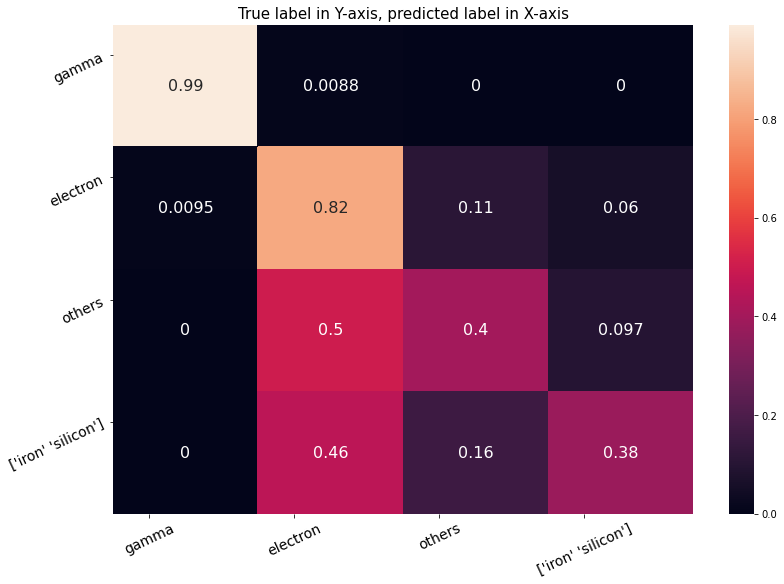

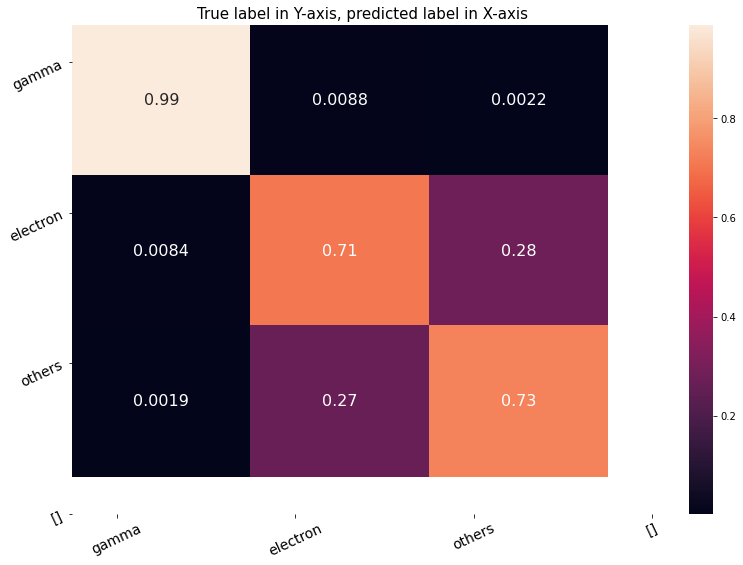

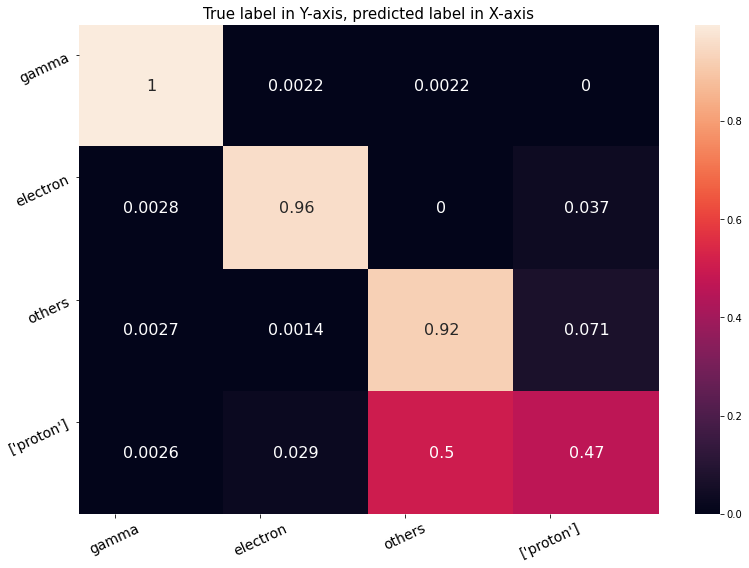

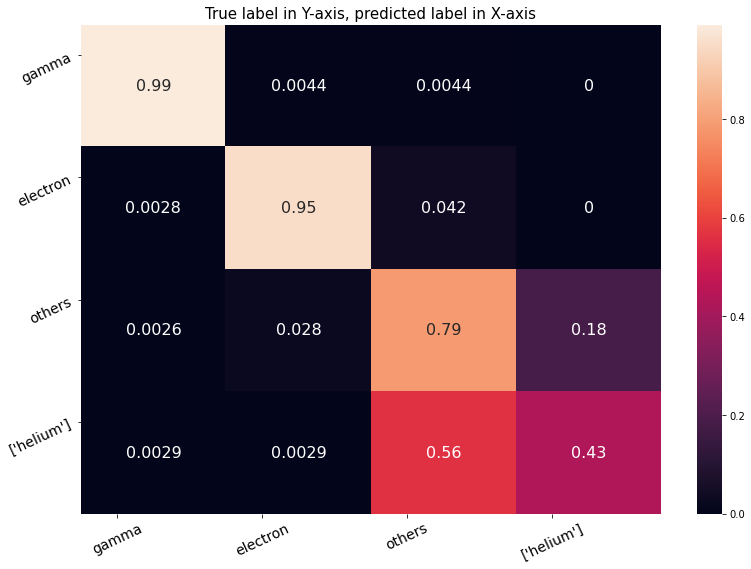

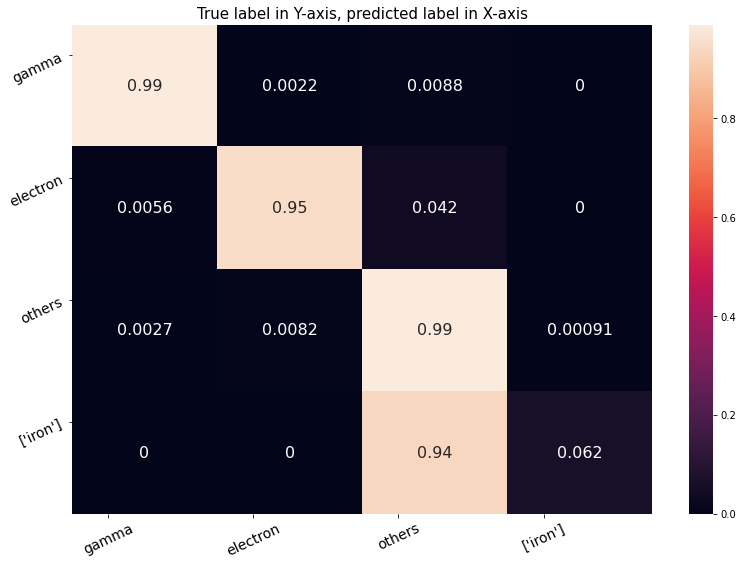

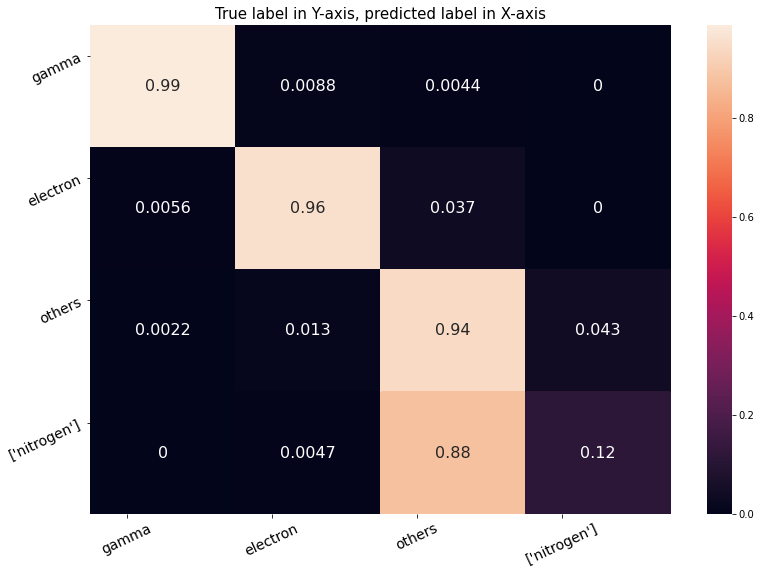

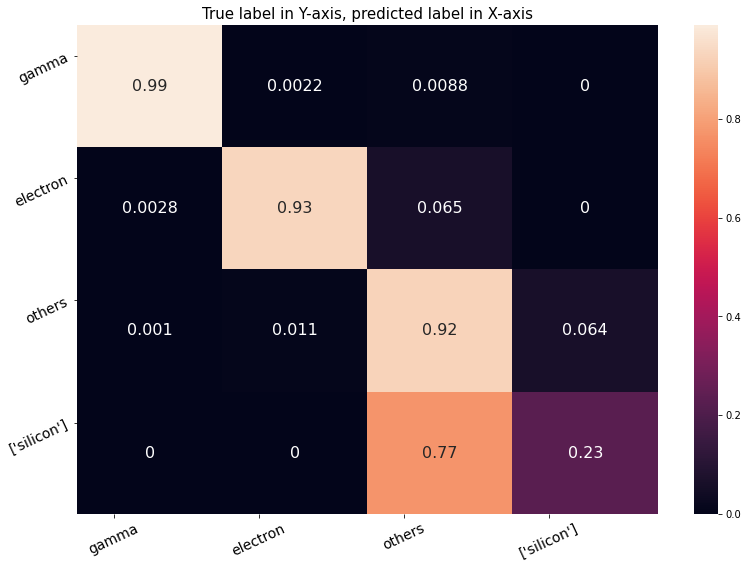

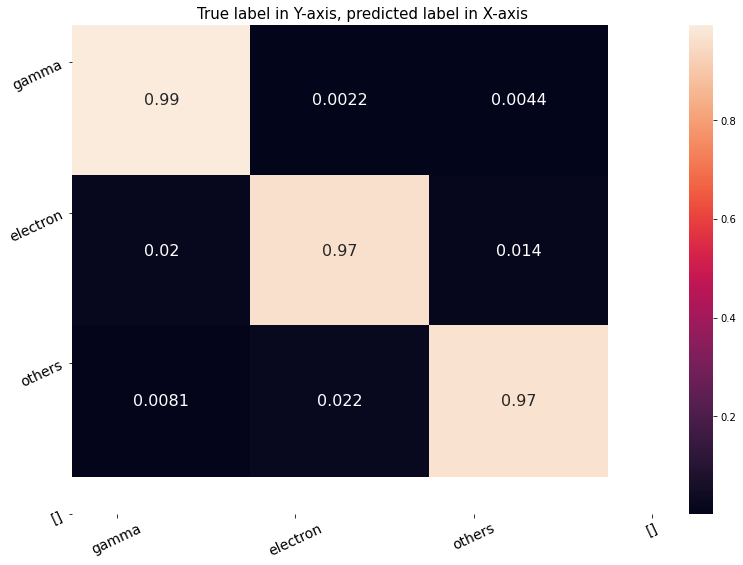

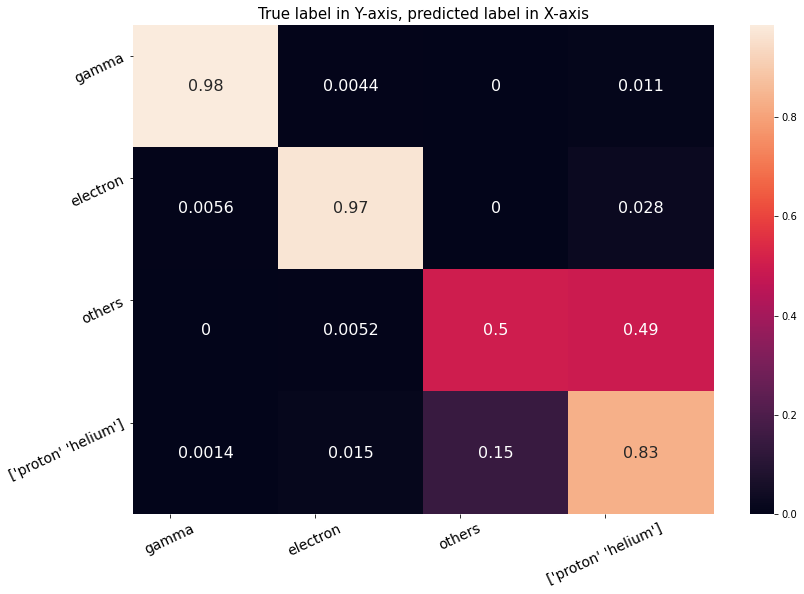

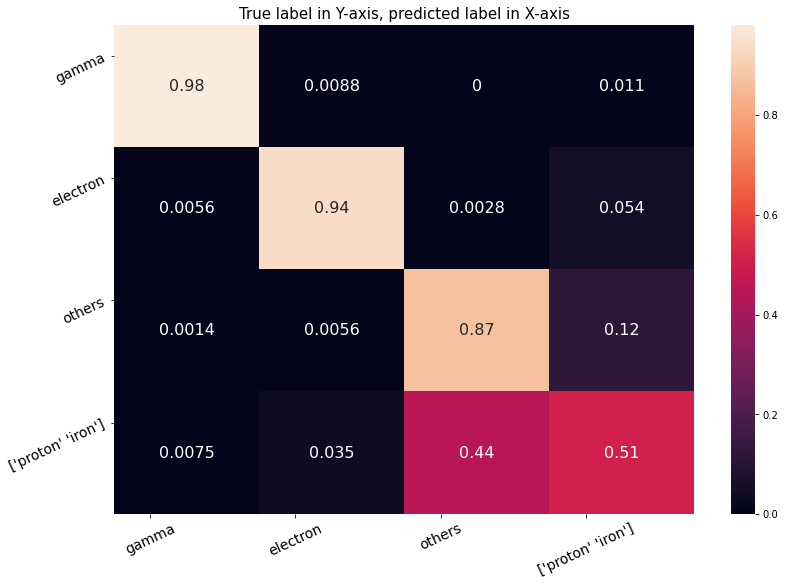

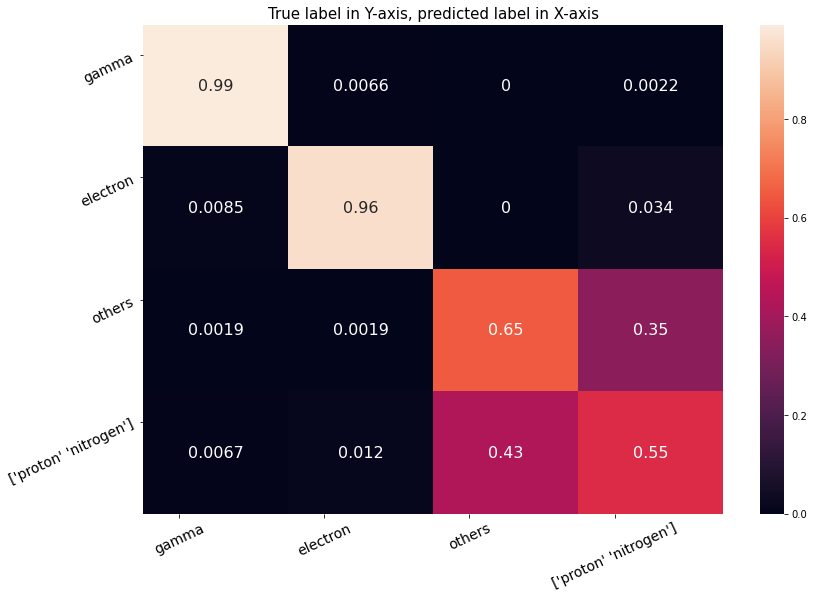

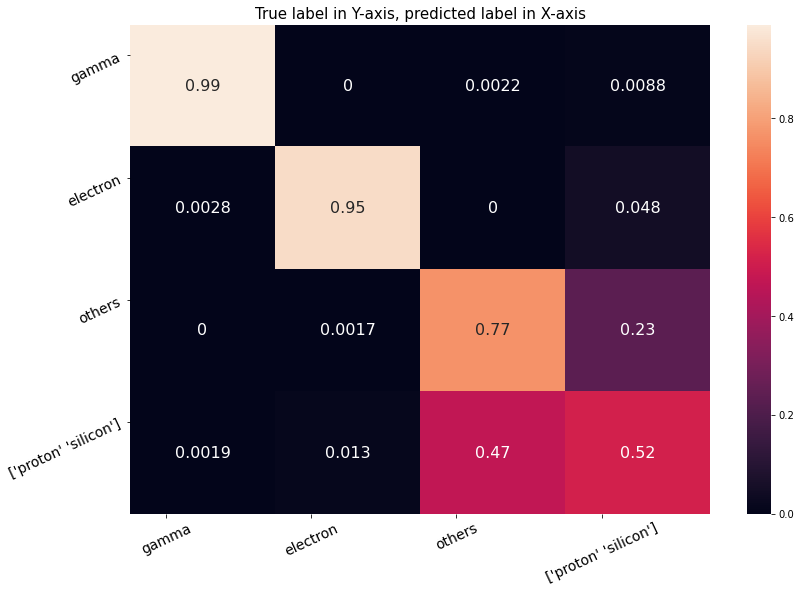

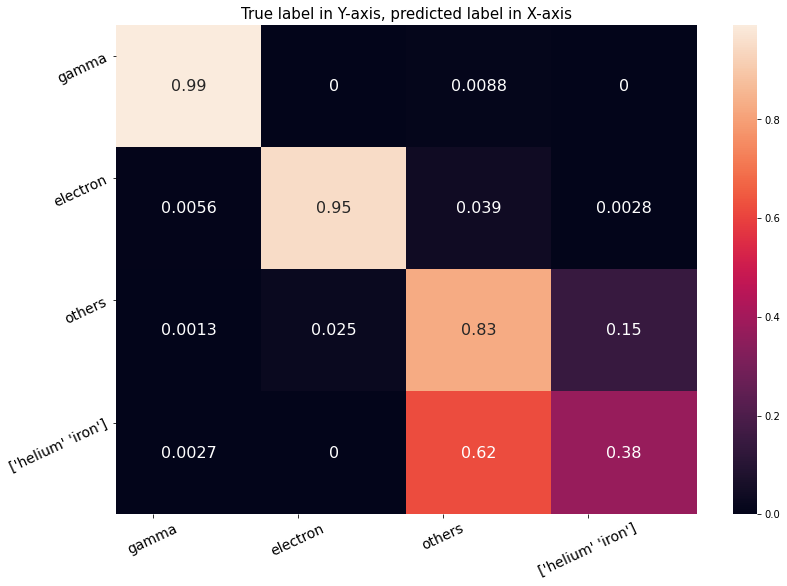

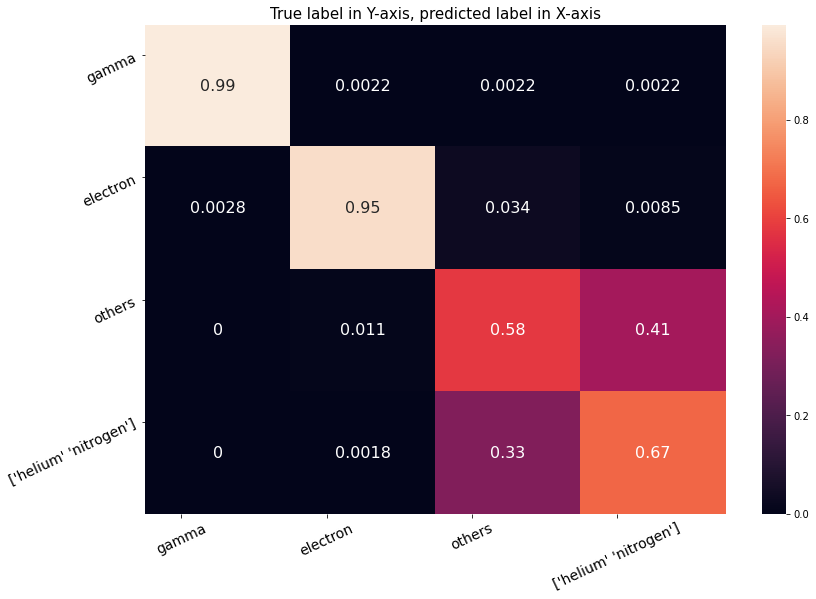

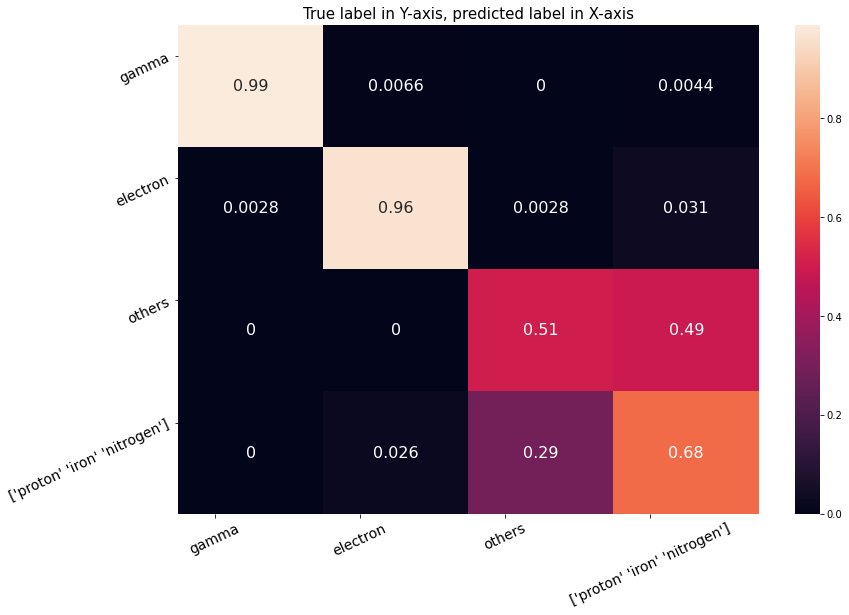

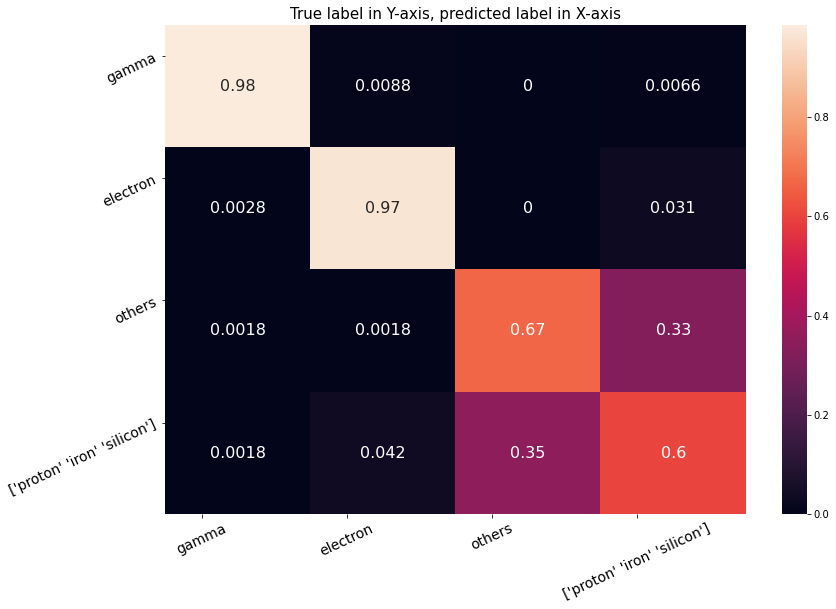

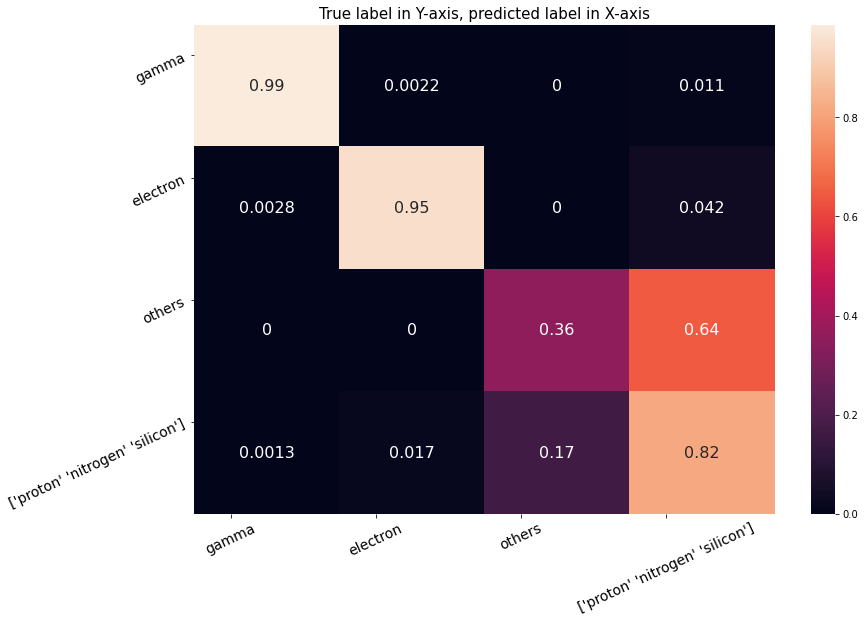

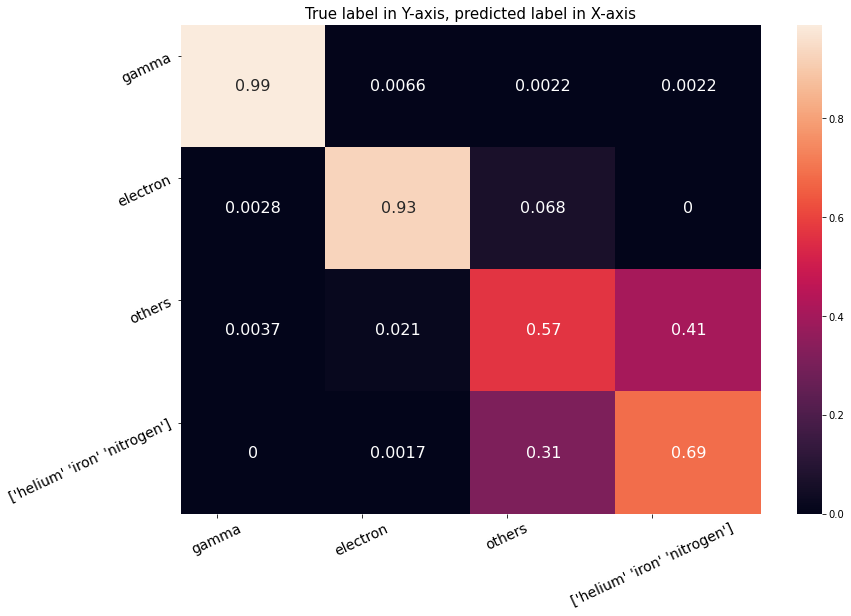

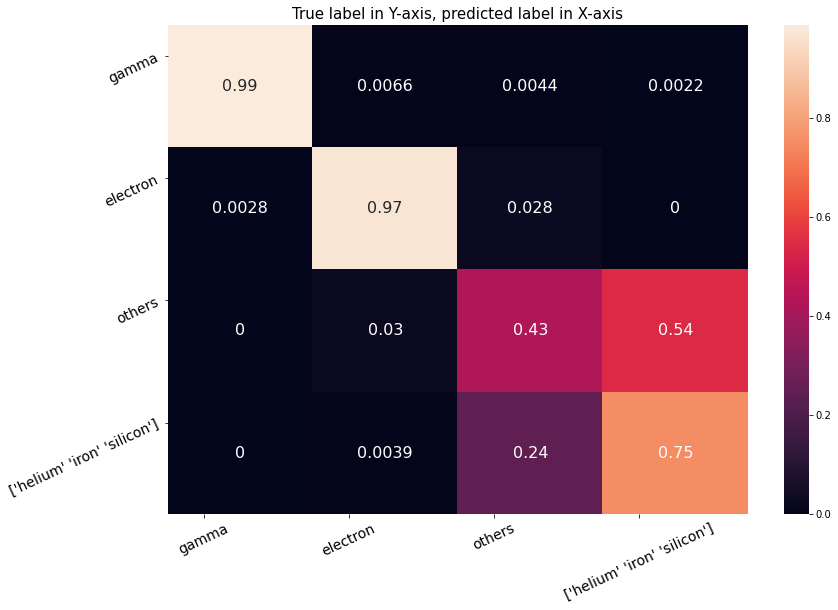

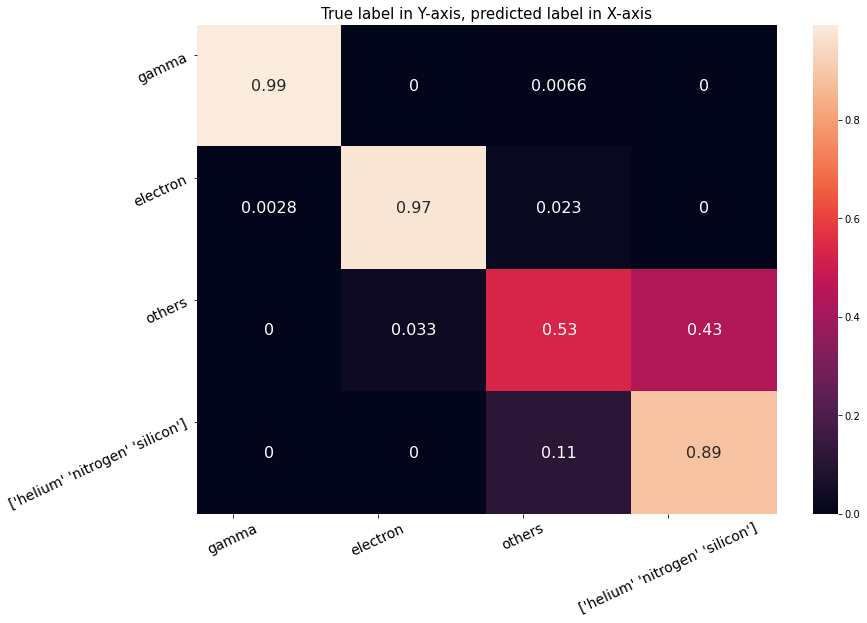

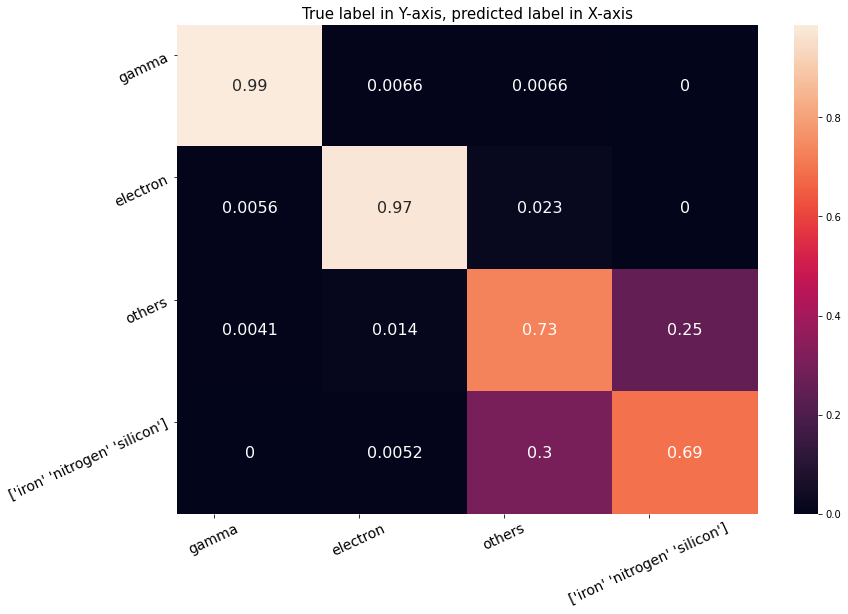

In [ ]:
#prueba 6 telescopio diferentes agrupaciones 
#vamos a darle diferentes labels
elements=np.array(["gamma","electron",'proton', 'helium', 'iron', 'nitrogen', 'silicon'])
aux_save_dir="/content/drive/MyDrive/MAIN_TFG/final_results/agrupaciones_6_telescopios"

lista_labels=np.array([[0,1,1,2,3,1,3],[0,1,1,2,2,1,2],[0,1,3,2,2,2,2],[0,1,2,3,2,2,2],[0,1,2,2,3,2,2],[0,1,2,2,2,3,2],
                       [0,1,2,2,2,2,3],[0,1,2,2,2,2,2],[0,1,3,3,2,2,2],[0,1,3,2,3,2,2],[0,1,3,2,2,3,2],[0,1,3,2,2,2,3],
                       [0,1,2,3,3,2,2],[0,1,2,3,2,3,2],[0,1,3,2,3,3,2],[0,1,3,2,3,2,3],[0,1,3,2,2,3,3],[0,1,2,3,3,3,2],
                       [0,1,2,3,3,2,3],[0,1,2,3,2,3,3],[0,1,2,2,3,3,3]])

i_aux=2
hist_total={}
for i,j in enumerate(lista_labels):
    #vamos a cambiar los y_test y y_train
    y_train_new=y_train.copy()
    y_test_new=y_test.copy()
    for m,n in enumerate(j):
        y_train_new[y_train==m]=n
        y_test_new[y_test==m]=n
    y_train_new=tf.keras.utils.to_categorical(y_train_new)
    y_test_new=tf.keras.utils.to_categorical(y_test_new)

    model=model_multi_tel(len_inputs=6,input_shapes=[(55,93,1),(55,93,1),(55,93,1),(55,93,1),(84,56,1),(84,56,1)],
                          classes=len(np.unique(j)),learning_rate=2e-5,last_dense=[150,50],filtros=[[32, 64], [128, 256], [64, 32], [16, 6]],common_pre=True)
    hist_aux=model.fit(x_train,y_train_new,epochs=50,batch_size=64,validation_data=(x_test,y_test_new))

    #vamos a guardar la conf matrix y la hist

    hist_total[str(j)]=hist_aux.history
    comp_and_diplay_conf_matrix(y_test_new,model.predict(x_test),["gamma","electron","others",str(elements[j==3])],sin_diag=False)
    plt.savefig(f"{aux_save_dir}/{str(j)}_confmatrix_6tels.png")
    aux2=json.dumps(hist_total)
    with open(f"{aux_save_dir}/agrupaciones_6tel_parte_{i_aux}.json","w") as fil2:
        fil2.write(aux2)
    print(i+1, "de", len(lista_labels),"\n")
print("Termino!")


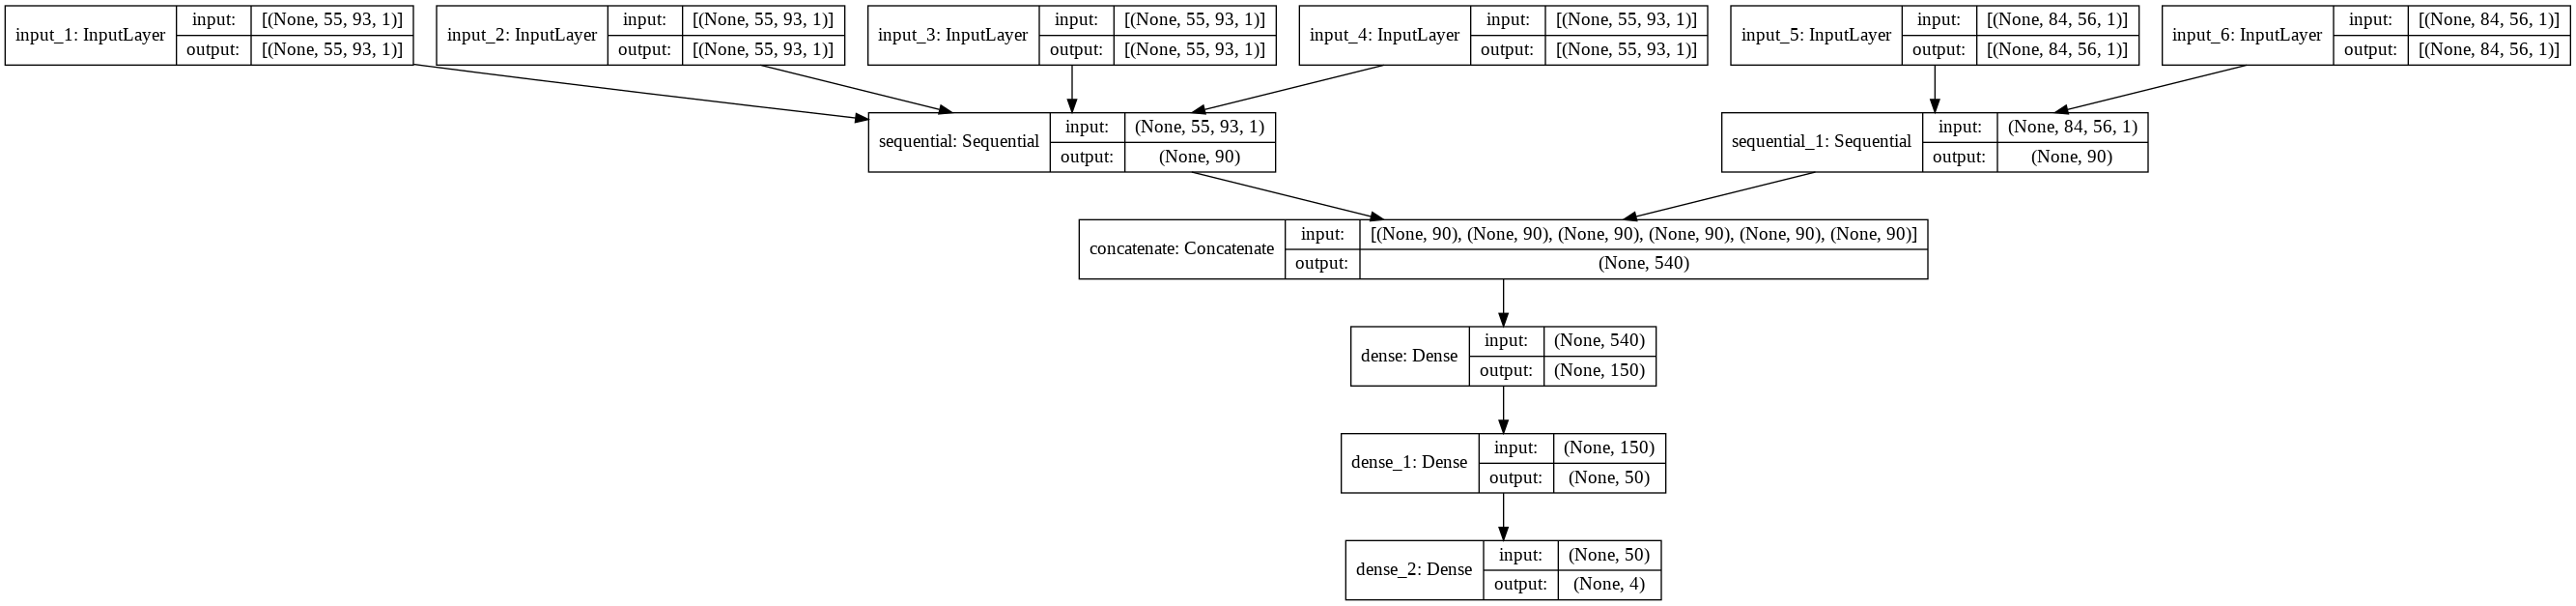

In [ ]:
    model=model_multi_tel(len_inputs=6,input_shapes=[(55,93,1),(55,93,1),(55,93,1),(55,93,1),(84,56,1),(84,56,1)],
                          classes=len(np.unique([0,1,2,2,3,2,2])),learning_rate=2e-5,last_dense=[150,50],filtros=[[32, 64], [128, 256], [64, 32], [16, 6]],common_pre=True)
    tf.keras.utils.plot_model(model,show_shapes=1)

# Resultados prediccion energía

In [ ]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow.keras.backend as K
import re
from sklearn.metrics import confusion_matrix
import seaborn as sns

#funciones necesarias pra la parte d energia

In [ ]:
# funcion de carga más personalizada

#primero funcion que carga los datos al darle unos telescopios y runs 
def load_data(npy_dir,tels=None,runs=None,indices_runs=None,only_names=False,ending=".npy",test_size=0.2):
    #aplicamos regular expresions para extraer los documentos deseados
    #usamos glob
    #si no pasamos ni los tesls ni las runs, deolvemos todos los arichivos
    #es poco optimo este uso de glob, pero es mas flexivo porque le puedo pasar los tels concretos y los runs concretos
    #si es return sin labels, nos devuelve todo, sin separar siquiera

    lista=[]
    if ((type(tels)==list) or (type(tels)==np.ndarray)):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            for j in runs:
                regex=f"{npy_dir}/*_tel_{i}_run_{str(j).zfill(2)}_?{ending}"
                aux=glob.glob(regex)
                if aux:
                    lista.extend(aux)
                else:
                    #si no lo encuentra entonces nos saldra mal la cosa
                    print("ERROR")
                    print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")
    else:
        for j in runs:
            regex=f"{npy_dir}/*_tel_{tels}_run_{str(j).zfill(2)}_?{ending}"
            aux=glob.glob(regex)
            if aux:
                lista.extend(aux)
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")

    if only_names:
        return lista
    else:
        if indices_runs is not None:
            if indices_runs[0].size==0:
                no_salir=True
                i=1
                while no_salir:
                    if indices_runs[i].size==0:
                        i+=1
                    else:
                        lista_npy=np.load(lista[i])[indices_runs[i]]
                        no_salir=False
                        i+=1
                for m,k in enumerate(lista[i:]):
                    if indices_runs[m+1].size!= 0:
                        lista_npy=np.concatenate((lista_npy,np.load(k)[indices_runs[m+1]]),axis=0)
                return lista_npy
            else:
                lista_npy=np.load(lista[0])[indices_runs[0]]
                for m,k in enumerate(lista[1:]):
                    if indices_runs[m+1].size!= 0:
                        lista_npy=np.concatenate((lista_npy,np.load(k)[indices_runs[m+1]]),axis=0)
                return lista_npy

        else:
            lista_npy=np.load(lista[0])
            for m,k in enumerate(lista[1:]):
                lista_npy=np.concatenate((lista_npy,np.load(k)),axis=0)
            return lista_npy

#ahora tenemos que saber cuales son los elementos que se comparten entre todos los telescopios


def get_common_events_energy(npy_dir_base,tels=None,run=None,array_from_txt=None,return_eventos=False):
    #esta funcion nos sirve para obtener los indices de eventos comunes tal que 
    #esto es necesario para que las imagenes sean del mismo evento

    #TENEMOS QUE MIRAR PARA UNA RUN, TODOS LOS TELESCOPIOS QUE NOS INTERESEN,
    #SIN IMPORTAR EL ELEMENTO, SOLO LOS TELESCOPIOS DE LA RUN Y EL EMENTO QUE TOQUE
    lista=[]
    if (type(tels)==list) or (type(tels)==np.ndarray):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            regex=f"{npy_dir_base}/id_eventos_*_tel_{i}_run_{str(run).zfill(2)}.npy"
            aux=glob.glob(regex)
            if aux:
                lista.append(np.load(aux[0]))
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir_base)} no se encuentra el {os.path.basename(regex)}.")
    else:
        print("ERROR")
        return None
    if len(tels)==1:
        if array_from_txt:
            sets=[set(i) for i in array_from_txt]
            eventos_comunes=sorted(list(set(lista[0]).intersection(*sets)))
        else:
            eventos_comunes=lista[0]
    else:
        sets=[set(i) for i in lista]
        if array_from_txt:
            for i in array_from_txt:
                sets.append(set(i)) 

        #devolvemos una lista de los INDICES de los eventos que SON COMUNES y podemos coger
        eventos_comunes=sorted(list(sets[0].intersection(*sets[1:])))
        del sets
    indices_master=[]
    indices_txt_master=[]
    for i,j in enumerate(tels):
        #no solo queremos que nos devuelva los indices para buscarlo en los npy, tambien para buscarlo en los txt
        indices=[]
        indices_txt=[]
        for k in eventos_comunes:
            indices.append(np.where(lista[i]==k)[0][0])
            indices_txt.append(np.where(array_from_txt[i]==k)[0][0])
        indices_master.append(np.array(indices))
        indices_txt_master.append(np.array(indices_txt))

    if return_eventos:
        return np.array(indices_master),np.array(indices_txt_master),np.array(eventos_comunes)
    else:
        return np.array(indices_master),np.array(indices_txt_master)



#por ultimo la funcion que nos va a administrar toda la carga de datos, aqui es donde pondemos la funcion de elergir el numero de runs para cada elementos


#MODIFICACION PARA QUE HAYA MAS O MENOS LA MISMA CANTIDAD DE DATOS DE CADA UNO.
def load_dataset_energy(base_dir_npy,base_dir_txt,elementos=None,lista_list_runs=None,pre_name_folders_npy="npy_",pre_name_folders_txt="extract_",
                        telescopios=None,test_size=0.2,same_quant="same",verbose=True,fill=False):
    #LOS TELESCOPIOS EN UNA LISTA AUNQUE SEA 1
    #la estructura de datos esperada es una carpeta contenedora de las carpetas con los archivos npy
    #y prename folder es eso que va delante del nombre de la carpeta que tiene el nombre del elemento

    #los labels son las energis que se obtienen de los txt

    #por ultimo da igual qeu tomemos muchas runs de uno si ponemos same_quant=same se nos quedará la cantidad exacata de cada
    #si ponemos same_quant=aprox mas o menos igual de cada uno  (se toma la mediana de la cantidad total de datos de cada clase considerada)
    #same_quant = "element" existe porque no es lo mis que haya la misma cantida por cada elemento qeu por cada label, entonces hay que tener eso en cuenta

    if elementos==None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']


    if len(lista_list_runs)!=len(elementos):
        #como lista_list_runs es una lista de las runs que vamos a tomar, pues deber haber una para cada elemento
        print("Error con la long de los elementos y las runs")
        return None


    #para cada elemento y para cada RUN tenemos que indicar los eventos validos
    energia_label=[]
    eventos_elementos=[]
    numero_eventos=[]
    for i,j in enumerate(elementos):
        dir_aux=f"{base_dir_npy}/{pre_name_folders_npy}{j}"
        eventos_runs=[]
        list_runs=lista_list_runs[i]
        aux_num_events=0
        energia_label_aux=[]
        for l,k in enumerate(list_runs):
            #todo esto es para aplicar el get_common events a todas las runs que debemos comprobar
            event_aux=get_txt_info(base_dir_txt,extension=pre_name_folders_txt,cols=0,tel=telescopios,run=k,element=j,cols_order=True)
            #ahora tambien tenemos que estar en concordancia con los eventos que se encuentran en los txt
            aux_events,aux_events_energy=get_common_events_energy(dir_aux,tels=telescopios,run=k,array_from_txt=event_aux,return_eventos=False)

            #ahora tenemos los eventos de cada txt y los que sí se van a usar
            #solo tenemos que conseguir un array con los indices
            if verbose:
                print(j,k,list_runs,aux_events.shape,aux_events_energy.shape)
            energia=get_txt_info(base_dir_txt,extension=pre_name_folders_txt,cols=2,tel=telescopios[0],run=k,element=j,cols_order=True)
            if len(aux_events_energy[0])!=0:
                energia_label_aux.extend(energia[aux_events_energy[0]])

            eventos_runs.append(aux_events)
            aux_num_events+=aux_events.shape[1]
        if len(energia_label_aux)!=aux_num_events:
            print("Error con las dimensiones que de labels y features")
            return None
        energia_label.append(np.array(energia_label_aux))
        numero_eventos.append(aux_num_events)
        eventos_elementos.append(eventos_runs)
    #esto es lo mas lioso
    #eventos_elementos=[gamma:[run1:[tel1:[eventos en tel1 comunes entre telescopios en run 1 para gamma],tel2:[eventos],...],
                              #run2:[tel1:[eventos],tel2:[ev...]],run3:[...]] ,electron:[run1:[...],run2:[...]],....]


    #ahora tenemos los eventos que sí nos valen porque estan en todos los telescopios a considerar 
    x_train_list=[]
    x_test_list=[]

    if verbose:
        print("_______________")

    
    if (same_quant=="approx") :
        cantidad=int(np.median(numero_eventos))
        print(cantidad)

            
    elif (same_quant=="same") :
        cantidad=int(np.amin(numero_eventos))
        print(cantidad)


    for l,k in enumerate(telescopios):
        for i,j in enumerate(elementos):
            dir_aux=f"{base_dir_npy}/{pre_name_folders_npy}{j}"
            list_runs=lista_list_runs[i]
            #TENEMOS QUE TENER UNA LISTA DE LOS INDICES/eventos QUE SÍ COMPARTEN ID, EL RESTO NO NOS INTERESA
            #lo que hacemos es pasarle una lista de los indices PARA:
            #PARA el elemento que toca y el telescopio qeu toca, para todas las runs que queremos 
            data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:] for m in eventos_elementos[i]],only_names=False)

            if same_quant in ["same","approx"]:
                data_aux=data_aux[:cantidad]
                if l==0:
                    energia_label[i]=energia_label[i][:cantidad]
            elif same_quant=="all":
                pass

            if fill:
                #aplicamos la funcion que nos rellena todo
                for p in range(data_aux.shape[0]):
                    data_aux[p,:,:]=fill_holes(data_aux[p])

            if verbose:
                print(j,k,data_aux.shape)
                if l==0:
                    print(energia_label[i].shape)
            if i==0 :
                data=data_aux
            else:
                data=np.concatenate((data,data_aux),axis=0)
                del data_aux
        #ahora le aumentamos el canal y las labels las volvemos categorical
        data=data[...,np.newaxis]
        if l==0:
            energia_label=np.concatenate([h for h in energia_label])
            print(energia_label.shape,data.shape)
            x_train,x_test,y_train,y_test =train_test_split(data,energia_label,test_size=test_size,random_state=42)
            del data
            y_train_list=y_train
            y_test_list=y_test
            x_train_list.append(x_train)
            x_test_list.append(x_test)
        else:
            x_train,x_test =train_test_split(data,test_size=test_size,random_state=42)
            x_train_list.append(x_train)
            x_test_list.append(x_test)
            del data

        if (x_train.shape[0]!=y_train.shape[0]) or (x_test.shape[0]!=y_test.shape[0]):
            print("Ha habido algún problema con las dimensiones y eso...te jodes lo siento")
            return None
        del x_train,x_test

    print("EXITO")
    if len(telescopios)==1:
        return x_train_list[0],x_test_list[0],y_train_list,y_test_list
    else:
        return x_train_list,x_test_list,y_train_list,y_test_list

In [ ]:
#una funcion para crear la lista de list runs 
def create_lista_list_runs(num_events,init_events=None,random_select=False,elementos=None,max_runs=None):
    #solo tenemos que indicar la cantidad de runs que queremos de cada uno de los elementos
    #tambien podemos indicar el numero maximo de runs disponibles y si los queremos aleatorios
    if type(init_events)==int:
        if init_events==0:
            init_events=1
        init_events=np.ones(len(num_events))*init_events
    if elementos is None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    if max_runs is None:
        max_runs=[41,40,40,40,20,40,40]
    lista_master=[]
    for i,j in enumerate(num_events):
        if random_select:
            if j> max_runs[i]:
                print("No hay tantas runs.")
                list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=max_runs[i])
            else:
                list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=j)
        else: 
            if init_events is not None:
                if (j+init_events[i]-1)> max_runs[i]:
                    print(f"Error, para el {i} te estas pasando de run, no hay runs {np.arange(max_runs[i]+1,init_events[i]+j+1,dtype=int)}")
                    if init_events[i] > max_runs[i]:
                        list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=j)
                    else:
                        list_aux=np.arange(init_events[i],1+max_runs[i],dtype=int)
                else:
                    list_aux=np.arange(init_events[i],j+init_events[i],dtype=int)


            else:
                if (j) > max_runs[i]:
                    print(f"Error, para el \"{elementos[i]}\" te estas pasando de run, no hay run {np.arange(max_runs[i]+1,j+2,dtype=int)}")
                    list_aux=np.arange(1,max_runs[i]+1,dtype=int)
                else:
                    list_aux=np.arange(1,j+1,dtype=int)
        lista_master.append(list_aux)
    return np.array(lista_master,dtype=object)

def fill_holes(npy):
    npy_aux=npy.copy()
    if type(npy)!=np.ndarray:
        print("Error input")
        return
    #para cada elemento que sea cero lo rellenamos con la media de los vecinos
    indices=np.where(npy[1:-1,1:-1]==0)
    indices_1=indices[1]+1
    indices_0=indices[0]+1
    for i in range(indices_1.shape[0]):
        #esto se podría vectorizar
        media=(npy[indices_0[i]-1,indices_1[i]]+npy[indices_0[i],indices_1[i]-1]+npy[indices_0[i]+1,indices_1[i]]+npy[indices_0[i],indices_1[i]+1])/4
        npy_aux[indices_0[i],indices_1[i]]=media
    del npy
    return npy_aux




In [ ]:
def lista_dt(dt_dir):
    return sorted(glob.glob(f"{dt_dir}/*.dt"))
def lista_txt(txt_dir):
    return sorted(glob.glob(f"{txt_dir}/*.txt"))

In [ ]:
def extract_info_txt(txt_dir,cols=None,cols_order=True):
  #extraer la informacion relevante de un archivo .txt
  #si se le pasan ciertas columnas se devolvera una lista solo con esas columnas
    cols_names=["event"
    ,"telescope"
    ,"energy"
    ,"core distance to telescope"
    ,"image size (amplitude) [p.e.]"
    ,"number of pixels in image"
    ,"width [deg.]"
    ,"length [deg.]"
    ,"distance [deg.]"
    ,"miss [deg.]"
    ,"alpha [deg.]"
    ,"orientation [deg.]"
    ,"direction [deg.]"
    ,"image c.o.g. x [deg.]"
    ,"image c.o.g. y [deg.]"
    ,"Xmax [g/cm^2]"
    ,"Hmax [m]"
    ,"Npe (true number of photo-electrons)"
    ,"(19-23): Hottest pixel amplitudes)"]
    with open(txt_dir,"r") as file:
        text_aux=file.read()
        a=re.findall(r'@\+[\s\d.-]*\d',text_aux)
        a=[i.replace("@+ ","").split() for i in a]
    if cols is None:
        return np.array(a).astype("float")
    elif type(cols)==list or type(cols)==np.array:
        list_aux=[]
        if cols_order :
            for i in cols:
                list_aux.append(np.array([float(j[i]) for j in a]))
            return np.array(list_aux).astype("float")
        else:
            list_aux=[]
            for i in a:
                list_aux.append(np.array([i[j] for j in cols ]))
            return np.array(list_aux).astype("float")

    else:
        return np.array([float(j[cols]) for j in a]).astype("float")

In [ ]:
#ahora necesitamos poder indicar el telescopio, la run y el elemento para que nos lo devulve
def get_txt_info(base_dir,extension="extract_",tel=None,run=None,element=None,cols=None,cols_order=True,ending=".txt"):
    if (type(tel)==list) or (type(tel)==np.ndarray):
        list_return=[]
        for i in tel:
            regex=f"{base_dir}/{extension}{element}/{element}_tel_{i}_run_{str(run).zfill(2)}{ending}"
            aux=glob.glob(regex)
            if aux:
                list_return_aux=extract_info_txt(aux[0],cols=cols,cols_order=cols_order)
                list_return.append(list_return_aux)
            else:
                print("Error, archivo no encontrado")
                return None
    else:
        regex=f"{base_dir}/{extension}{element}/{element}_tel_{tel}_run_{str(run).zfill(2)}{ending}"
        aux=glob.glob(regex)
        if aux:
            list_return=extract_info_txt(aux[0],cols=cols,cols_order=cols_order)
        else:
            print("Error, archivo no encontrado")
            return None

    return list_return

In [ ]:
def model_1_tel(input_shape=(55,93,1),filtros=None,batch_init=True,last_layers=None,avg_pooling=None,learning_rate=1e-5,first_model=None,first_part=False):
    if filtros is None:
        filtros=[[64,32],[128,64,64],[32,16]]
    if last_layers is None:
        last_layer=[35,20]
    #lo vamos a hacer super customizable para probar esa vaina de entrenar muchos hiperparametros
    #estructura lo que nos mete son el numero de filtros conv y maxpool
    model=tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=input_shape)])
    if first_model:
        first_model.trainable=False
        model.add(first_model)
    if batch_init:
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation("relu"))
    for i,j in enumerate(filtros):
        #aqui se alterna entre conv y maxpool(1) o average pool(-1)
        for k in j:
            model.add(tf.keras.layers.Conv2D(k,3,activation="relu"))
        if avg_pooling:
            model.add(tf.keras.layers.AveragePooling2D((2,2)))
        else:
            model.add(tf.keras.layers.MaxPool2D((2,2)))
    model.add(tf.keras.layers.Flatten())
    if first_part:
        return model
    for j,i in enumerate(last_layers):
        model.add(tf.keras.layers.Dense(i,activation="relu"))
    model.add(tf.keras.layers.Dense(classes,activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="categorical_crossentropy",metrics=["accuracy"])

    return model


def model_multi_tel(len_inputs=4,input_shapes=[(55,93,1)],learning_rate=1e-5,pre_proces_model=None,batch_init=False,filtros=None,last_dense=None,autoencoder=None,common_pre=True):
    inputs=[]
    outputs=[[] for i in range(len_inputs)]
    if len(input_shapes)==1:
        for i in range(1,len_inputs):
            input_shapes.append(input_shapes[0])

    for i in range(len_inputs):
        inputs.append(tf.keras.Input(shape=input_shapes[i]))

    if pre_proces_model:
        for i in range(len_inputs):
            outputs[i]=pre_proces_model(inputs[i],first_model=autoencoder)
    else:
        if filtros is None:
            filtros=[[64,128],[128,254,64],[32]]
        #si no le metemos un modelo pues habra que meter aqui chicha porque sino se queda esto muy vacio
        if common_pre:
            pre_model=model_1_tel(input_shapes[0],batch_init=batch_init,filtros=filtros,first_part=True,first_model=autoencoder)
            outputs[0]=pre_model(inputs[0])
            for i in range(1,len_inputs):
                if input_shapes[i]!=input_shapes[i-1]:
                #esto esta suponiendo que ponemos juntos los que tienen igual shape
                    pre_model=model_1_tel(input_shapes[i],batch_init=batch_init,filtros=filtros,first_part=True,first_model=autoencoder) 
                outputs[i]=pre_model(inputs[i])

        else:
            for i in range(len_inputs):
                pre_model=model_1_tel(input_shape=input_shapes[i],batch_init=batch_init,filtros=filtros,first_part=True)
                outputs[i]=pre_model(inputs[i]) 
    #nos falta la ultima parte
    if last_dense is None:
        last_dense=[65,25]
    x=tf.keras.layers.concatenate(outputs)
    for i in last_dense:
        x=tf.keras.layers.Dense(i,activation="relu")(x)
    end_layer=tf.keras.layers.Dense(1)(x)
    model=tf.keras.Model(inputs=inputs,outputs=end_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="mse")

    return model


#carga datos energia y entrena modelo

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 55, 93, 1)]  0                                            
____________________________________________________________________________________________

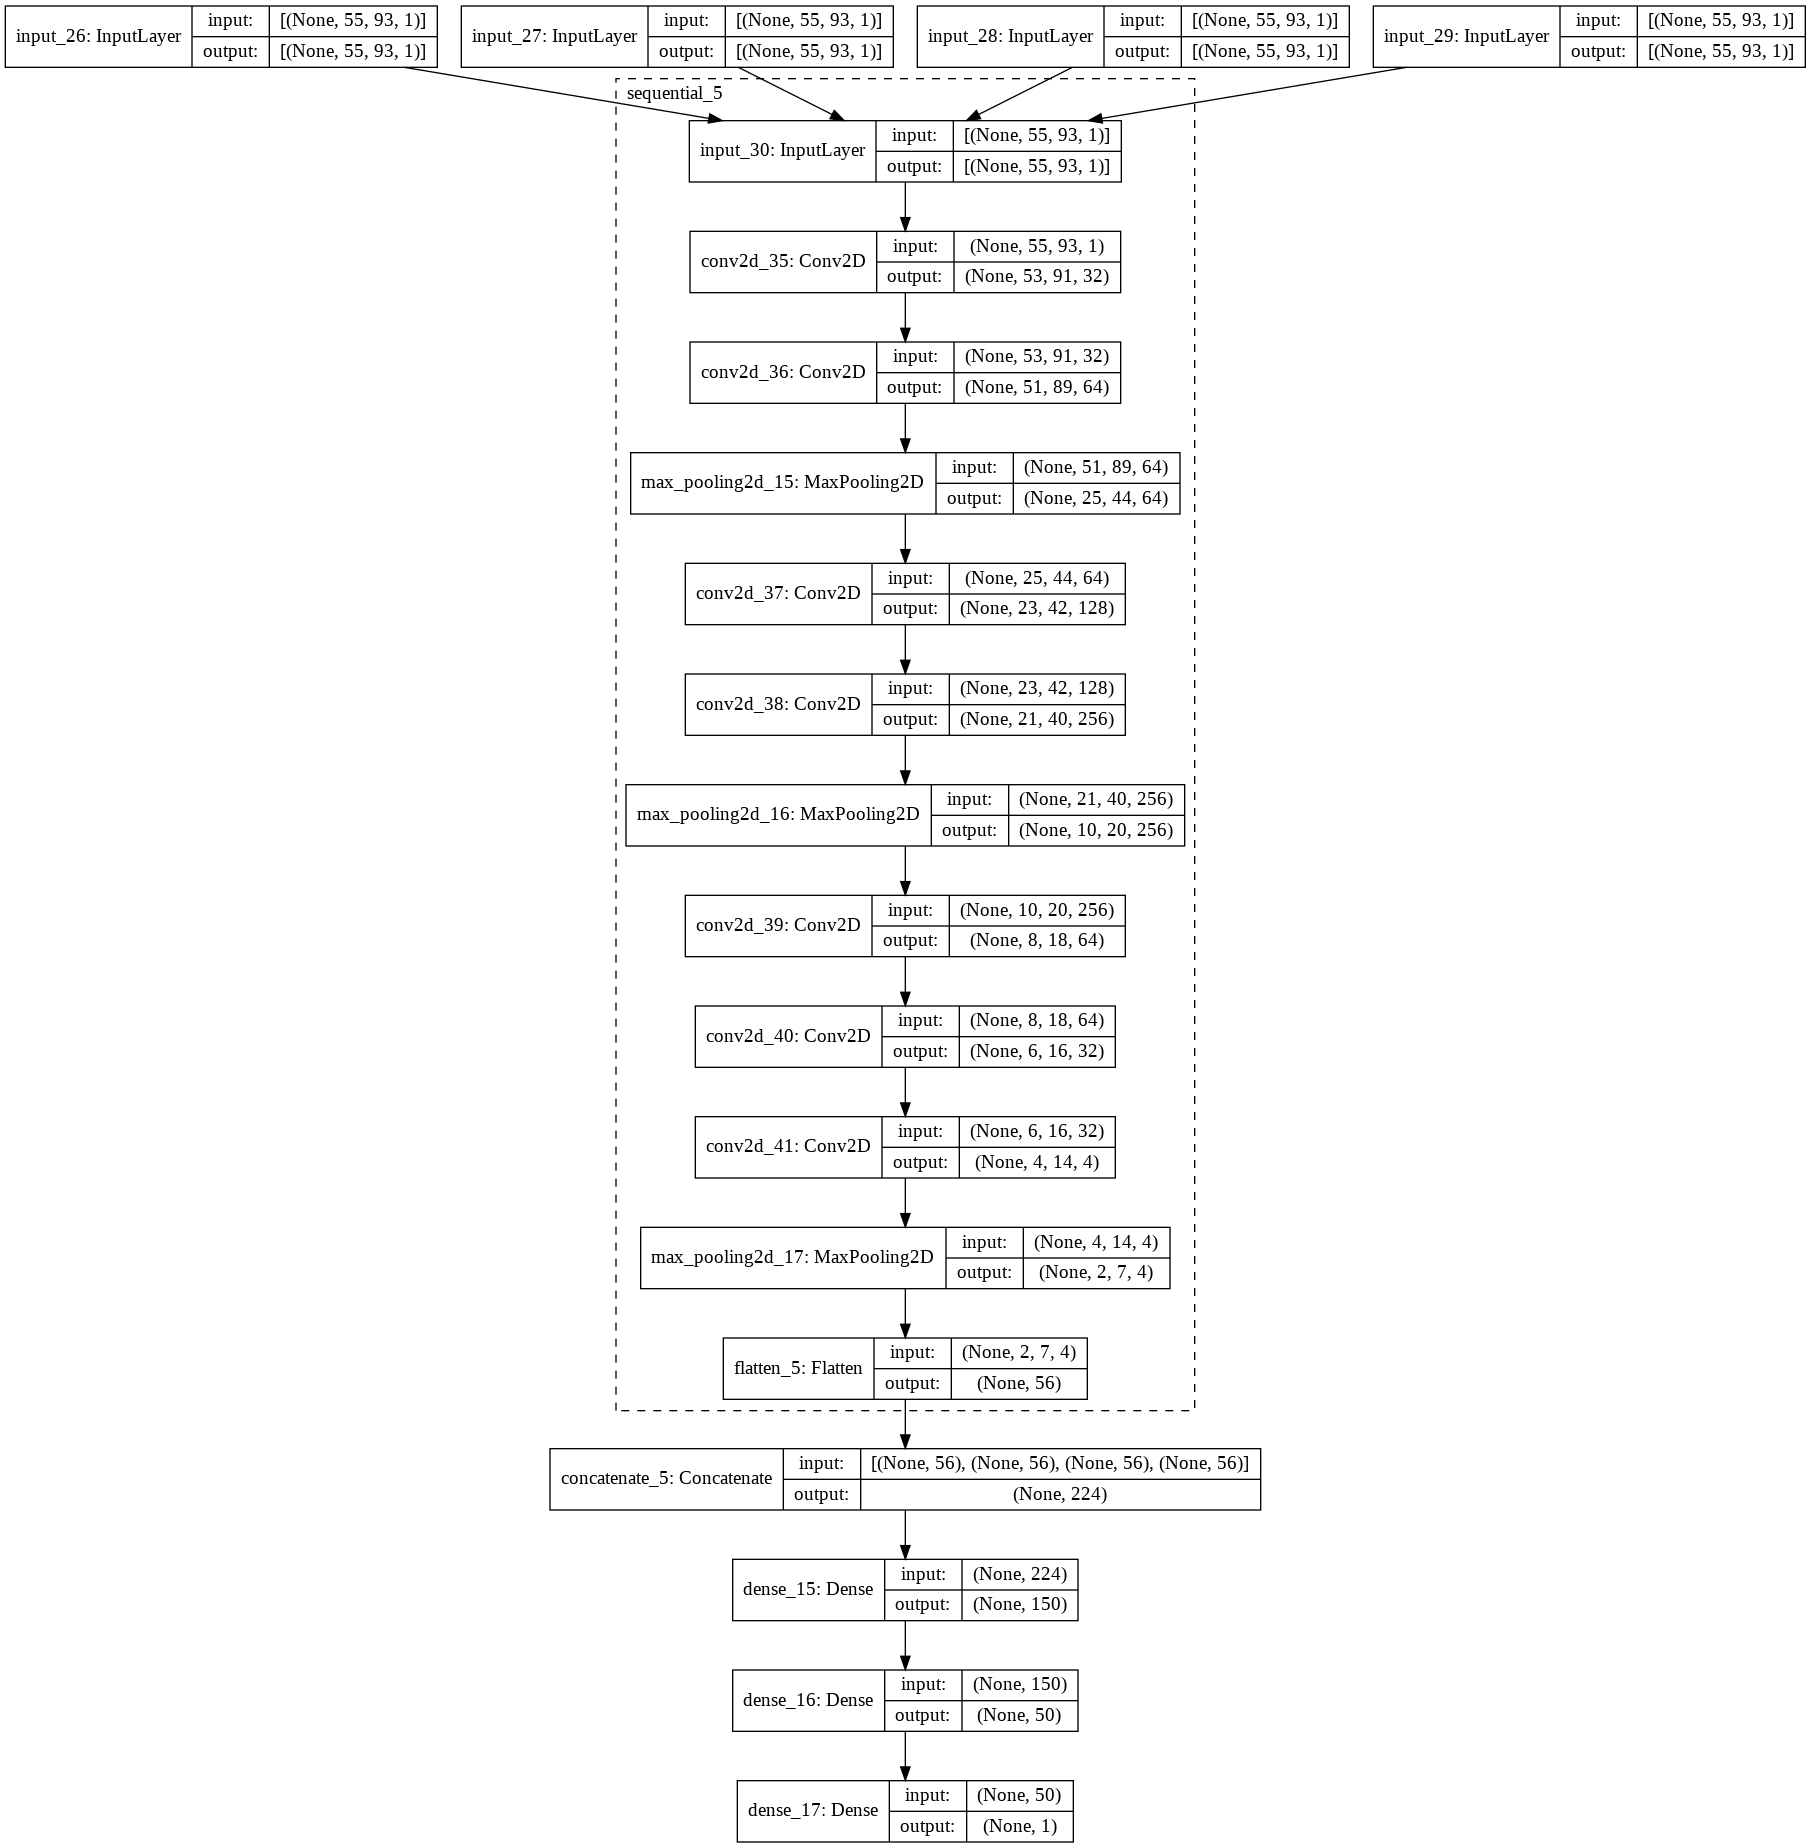

In [ ]:
model=model_multi_tel(learning_rate=1e-4,last_dense=[150,50],filtros=[[32, 64], [128, 256], [64, 32,4]],input_shapes=[(55,93,1),(55,93,1),(55,93,1),(55,93,1)],batch_init=False,common_pre=True)
model.summary()
tf.keras.utils.plot_model(model,expand_nested=True,show_shapes=True)


In [ ]:
a=create_lista_list_runs(num_events=[6,39],init_events=np.ones(2),random_select=False)
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
dir_base_txt="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
x_train,x_test,y_train,y_test=load_dataset_energy(npy_base,dir_base_txt,elementos=['gamma', 'electron'],lista_list_runs=a,telescopios=[4,5,6,11],test_size=0.2,same_quant="all",verbose=True,fill=True)


gamma 1 [1 2 3 4 5 6] (4, 1999) (4, 1999)
gamma 2 [1 2 3 4 5 6] (4, 1999) (4, 1999)
gamma 3 [1 2 3 4 5 6] (4, 1999) (4, 1999)
gamma 4 [1 2 3 4 5 6] (4, 1997) (4, 1997)
gamma 5 [1 2 3 4 5 6] (4, 1997) (4, 1997)
gamma 6 [1 2 3 4 5 6] (4, 1998) (4, 1998)
electron 1 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (4, 110) (4, 110)
electron 2 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (4, 105) (4, 105)
electron 3 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (4, 100) (4, 100)
electron 4 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (4, 125) (4, 125)
electron 5 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] (4, 125) (4, 125)
ele

In [ ]:
import json
hist=model.fit(x_train,y_train,epochs=70,batch_size=64,validation_data=(x_test,y_test))
#aux2=json.dumps(hist.history)
#with open("/content/drive/MyDrive/MAIN_TFG/final_results/energia/history_1.json","w") as fil2:
#    fil2.write(aux2)

Epoch 1/70
204/204 [==============================] - 15s 66ms/step - loss: 0.2264 - val_loss: 0.0551
Epoch 2/70
204/204 [==============================] - 12s 57ms/step - loss: 0.0451 - val_loss: 0.0353
Epoch 3/70
204/204 [==============================] - 12s 57ms/step - loss: 0.0303 - val_loss: 0.0312
Epoch 4/70
204/204 [==============================] - 12s 57ms/step - loss: 0.0247 - val_loss: 0.0276
Epoch 5/70
204/204 [==============================] - 12s 57ms/step - loss: 0.0188 - val_loss: 0.0240
Epoch 6/70
204/204 [==============================] - 12s 57ms/step - loss: 0.0165 - val_loss: 0.0213
Epoch 7/70
204/204 [==============================] - 12s 57ms/step - loss: 0.0140 - val_loss: 0.0194
Epoch 8/70
 45/204 [=====>........................] - ETA: 8s - loss: 0.0155

KeyboardInterrupt: ignored

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),loss="mse")
hist2=model.fit(x_train,y_train,epochs=30,batch_size=32,validation_data=(x_test,y_test))


In [ ]:
#model.save("/content/drive/MyDrive/MAIN_TFG/final_results/energia/history_1_energia.h5")
model=tf.keras.models.load_model("/content/drive/MyDrive/MAIN_TFG/final_results/energia/history_1_energia.h5")

In [ ]:
import seaborn as sns
from sklearn.metrics import r2_score as r2
import pandas as pd

(3250,)


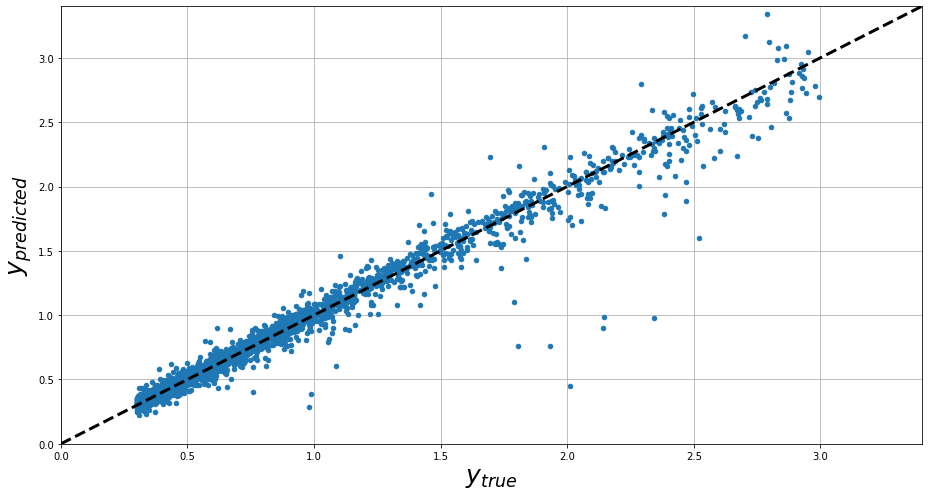

In [ ]:
plt.figure(figsize=(13,7))
plt.plot(y_test,model.predict(x_test),".",markersize=9)
plt.plot([0,3.4],[0,3.4],"k--",linewidth=3)
plt.grid()
plt.xlim([0,3.4])
plt.ylim([0,3.4])
plt.xlabel("$y_{true}$",fontsize=25)
plt.ylabel("$y_{predicted}$",fontsize=25)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MAIN_TFG/final_results/energia/y_treu_y_pred_gammaelectron.png")
print(y_test.shape)

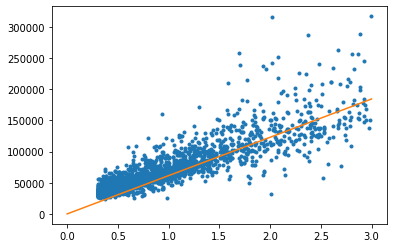

In [ ]:
#la suma de intensidades sera 
suma_ints=np.zeros(x_test[0].shape[0])
for i in range(4):
    suma_ints=suma_ints+np.sum(np.sum(x_test[i][:,:,:,0],axis=-1),axis=-1)

plt.plot(y_test,suma_ints,".")
ajuste=np.polyfit(y_test,suma_ints,1)
ajuste
plt.plot([0,3],[0,ajuste[0]*3+ajuste[1]])

In [ ]:
np.sqrt(7.77619325e-05)

0.00881827264831384

No handles with labels found to put in legend.


ajuste: (array([ 1.41906104e-05, -6.86146081e-02]), array([[ 1.60050743e-14, -9.60540496e-10],
       [-9.60540496e-10,  7.77619325e-05]]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


NameError: ignored

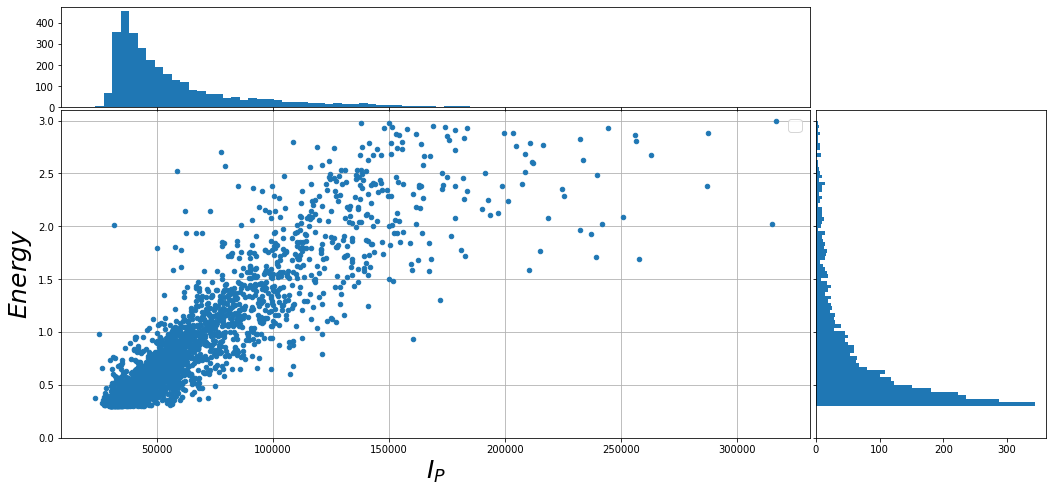

In [ ]:
#suma de intensidades
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(16,7))
ax = fig.add_axes(rect_scatter)
ajuste=np.polyfit(suma_ints,y_test,1,cov=True)
print("ajuste:",ajuste)
plt.plot(suma_ints,y_test,".",markersize=9)
plt.grid()
#plt.xlim([0,3.4])
plt.ylim([0,3.1])
plt.ylabel("$Energy$",fontsize=25)
plt.xlabel("$I_P$",fontsize=25)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histx.hist(suma_ints, bins=80,histtype="stepfilled")
ax_histy.hist(y_test, bins=80, orientation='horizontal')
#ax.plot([min(suma_ints),max(suma_ints)],[ajuste[0]*min(suma_ints)+ajuste[1],ajuste[0]*max(suma_ints)+ajuste[1]],"k--",linewidth=3.5,label=f"Linear fit $E_{{predicted}}=1.42 x 10^{{-5}} I_P {ajuste[1]:.2}$")
ax.legend(fontsize=17)
plt.tight_layout()
#plt.savefig("/content/drive/MyDrive/MAIN_TFG/final_results/energia/E_treu_E_sumaintensidades_gammaelectron_conhists.png")
print(r2(y_test,suma_ints))
print(np.corrcoef(y_test,suma_ints))


[ 1.41906104e-05 -6.86146081e-02]
0.7948180005150429
[[1.         0.89152566]
 [0.89152566 1.        ]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


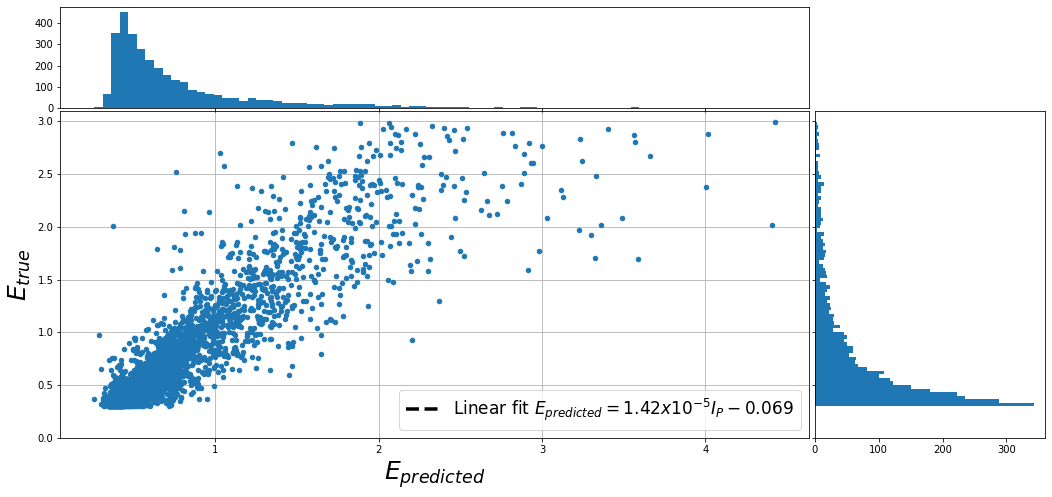

In [ ]:
#suma de intensidades PREDICCION
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
suma_ints=np.zeros(x_test[0].shape[0])
for i in range(4):
    suma_ints=suma_ints+np.sum(np.sum(x_test[i][:,:,:,0],axis=-1),axis=-1)


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(16,7))
ax = fig.add_axes(rect_scatter)
ajuste=np.polyfit(suma_ints,y_test,1)
print(ajuste)
y_pred=suma_ints*ajuste[0]+ajuste[1]
plt.plot(y_pred,y_test,".",markersize=9)
plt.grid()
#plt.xlim([0,3.4])
plt.ylim([0,3.1])
plt.ylabel("$E_{true}$",fontsize=25)
plt.xlabel("$E_{predicted}$",fontsize=25)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histx.hist(y_pred, bins=80,histtype="stepfilled")
ax_histy.hist(y_test, bins=80, orientation='horizontal')
ax.plot([min(y_pred),max(y_pred)],[ajuste[0]*min(y_pred)+ajuste[1],ajuste[0]*max(y_pred)+ajuste[1]],"k--",linewidth=3.5,label=f"Linear fit $E_{{predicted}}=1.42 x 10^{{-5}} I_P {ajuste[1]:.2}$")
ax.legend(fontsize=17)
plt.tight_layout()
#plt.savefig("/content/drive/MyDrive/MAIN_TFG/final_results/energia/E_treu_E_sumaintensidades_gammaelectron_conhists.png")
print(r2(y_test,y_pred))
print(np.corrcoef(y_test,y_pred))


In [ ]:
0.89152566**2

0.7948180024384356

In [ ]:
np.corrcoef(y_test,suma_ints)[0,1]**2

0.794818000515043

In [ ]:
np.corrcoef(y_test,model.predict(x_test).squeeze())

NameError: ignored

In [ ]:
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(16,7))
ax = fig.add_axes(rect_scatter)

plt.plot(y_test,model.predict(x_test).squeeze(),".",markersize=9)
plt.plot([0,3.4],[0,3.4],"k--",linewidth=3)
plt.grid()
plt.xlim([0,3.4])
plt.ylim([0,3.4])
plt.xlabel("$E_{true}$",fontsize=25)
plt.ylabel("$E_{predicted}$",fontsize=25)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histx.hist(y_test, bins=80,histtype="stepfilled")
ax_histy.hist(model.predict(x_test).squeeze(), bins=80, orientation='horizontal')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MAIN_TFG/final_results/energia/E_treu_E_sumaintensidades_gammaelectron_conhists.png")


#para diferentes elementos a ver si es capaz de predecir solo un tipo

In [ ]:
import json

In [ ]:
elements=np.array([['proton'], ['helium'], ['iron'], ['nitrogen'], ['silicon']])
cantidad=[[39],[39],[19],[39],[39]]
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
dir_base_txt="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
for i,j in enumerate(elements):
    a=create_lista_list_runs(num_events=cantidad[i],init_events=np.ones(len(j)),random_select=False)
    x_train,x_test,y_train,y_test=load_dataset_energy(npy_base,dir_base_txt,elementos=j,lista_list_runs=a,telescopios=[4,5,6,11],test_size=0.2,same_quant="all",verbose=True,fill=False)
    model=model_multi_tel(learning_rate=1e-4,last_dense=[150,50],filtros=[[32, 64], [128, 256], [64, 16,4]],input_shapes=[(55,93,1),(55,93,1),(55,93,1),(55,93,1)],batch_init=False,common_pre=True)
    hist=model.fit(x_train,y_train,epochs=60,batch_size=64,validation_data=(x_test,y_test))
    #aux2=json.dumps(hist.history)
    #with open(f"/content/drive/MyDrive/MAIN_TFG/final_results/energia/pred_energia_4tels_{str(j)}_part1.json","w") as fil2:
    #    fil2.write(aux2)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss="mse")
    hist2=model.fit(x_train,y_train,epochs=15,batch_size=32,validation_data=(x_test,y_test))
    model.save(f"/content/drive/MyDrive/MAIN_TFG/final_results/energia/model_pred_energia_4tels_{str(j)}.h5")
    y_pred=model.predict(x_test).squeeze()
    print("R2 ",j, r2(y_test,y_pred))
    print("rho ",j, np.corrcoef(y_test,y_pred))

    #aux2=json.dumps(hist2.history)
    #with open(f"/content/drive/MyDrive/MAIN_TFG/final_results/energia/pred_energia_4tels_{str(j)}_part2.json","w") as fil2:
    #    fil2.write(aux2)
    #plt.figure(figsize=(13,13,))
    #plt.plot(y_test,model.predict(x_test),".")
    #plt.plot([0,4],[0,4],"r--")
    #plt.savefig(f"/content/drive/MyDrive/MAIN_TFG/final_results/energia/imagen_acierto_pred_energia_4tels_{str(j)}.png")

proton 1 [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39] (4, 305) (4, 305)
proton 2 [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39] (4, 321) (4, 321)
proton 3 [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39] (4, 325) (4, 325)
proton 4 [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39] (4, 319) (4, 319)
proton 5 [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39] (4, 346) (4, 346)
proton 6 [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39] (4, 312) (4, 312)
proton 7 [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39] (4, 338) (4, 338)
proton 8 [1 2 3 4 5 6 7 8 9 10 11 

In [ ]:
#tambien vamos a hacer un ajuste lineal entre la suma de intensidaddes y la energia
a=create_lista_list_runs(num_events=[4,39],init_events=np.ones(2),random_select=False)
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
dir_base_txt="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
x_train,x_test,y_train,y_test=load_dataset_energy(npy_base,dir_base_txt,elementos=['gamma', 'electron'],lista_list_runs=a,telescopios=[4,5,6,11],test_size=0.2,same_quant="all",verbose=True,fill=False)


(8428,)

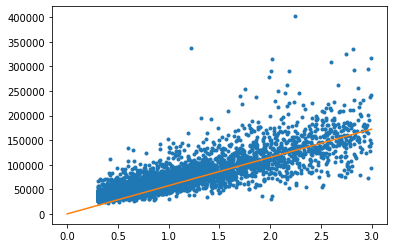

In [ ]:
#la suma de intensidades sera 
suma_ints=np.zeros(x_train[0].shape[0])
for i in range(4):
    suma_ints=suma_ints+np.sum(np.sum(x_train[i][:,:,:,0],axis=-1),axis=-1)

plt.plot(y_train,suma_ints,".")
ajuste=np.polyfit(y_train,suma_ints,1)
ajuste
plt.plot([0,3],[0,ajuste[0]*3+ajuste[1]])

In [ ]:
np.corrcoef(y_train,suma_ints)

array([[1.      , 0.874255],
       [0.874255, 1.      ]])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss="mse")
hist2=model.fit(x_train,y_train,epochs=30,batch_size=32,validation_data=(x_test,y_test))


Epoch 1/30
264/264 [==============================] - 29s 50ms/step - loss: 1.0621 - val_loss: 0.4778
Epoch 2/30
264/264 [==============================] - 12s 45ms/step - loss: 0.3178 - val_loss: 0.2763
Epoch 3/30
264/264 [==============================] - 12s 45ms/step - loss: 0.1990 - val_loss: 0.2027
Epoch 4/30
264/264 [==============================] - 12s 45ms/step - loss: 0.1503 - val_loss: 0.1575
Epoch 5/30
264/264 [==============================] - 12s 45ms/step - loss: 0.1236 - val_loss: 0.1327
Epoch 6/30
264/264 [==============================] - 12s 45ms/step - loss: 0.1052 - val_loss: 0.1191
Epoch 7/30
264/264 [==============================] - 12s 45ms/step - loss: 0.0916 - val_loss: 0.1015
Epoch 8/30
264/264 [==============================] - 12s 45ms/step - loss: 0.0811 - val_loss: 0.0893
Epoch 9/30
264/264 [==============================] - 12s 45ms/step - loss: 0.0725 - val_loss: 0.0809
Epoch 10/30
264/264 [==============================] - 12s 45ms/step - loss: 0.065

In [ ]:
np.corrcoef(y_train,model.predict(x_train).squeeze())

array([[1.       , 0.9751867],
       [0.9751867, 1.       ]])

In [ ]:
a=model.predict(x_train)

In [ ]:
a.squeeze()

array([1.1842924 , 0.37497166, 0.25947145, ..., 0.71019745, 0.59920824,
       2.5130684 ], dtype=float32)